In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pickle
import random
import umap
from tqdm import tqdm
from data.util.paths import DATA_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
tqdm.pandas()

In [ ]:
from lib.processing import save_to_pkl, load_from_pkl
from data.scripts.project_data import DataLoader
from data.util.environment_variables import COUNTRY_CODES, M49_TO_ISO3

In [3]:
concat_df = load_from_pkl('concat')
concat_columns = set(concat_df.columns)

In [4]:
get_col_set = lambda x: set([column for column in concat_columns if x in column])

In [5]:
format_description_columns = get_col_set('format_description_')
format_name_columns = get_col_set('format_name_')
format_columns = set([*format_description_columns,*format_name_columns,'format_text_clean','format_quantity'])

In [6]:
superregion_columns, region_columns, country_columns = (get_col_set(string) for string in ('superregion_','region_','country_'))
geography_columns = set([*superregion_columns,*region_columns,*country_columns])

In [7]:
period_columns,era_columns,genre_columns,style_columns = (get_col_set(string) for string in ('period_','era_','genre_','style_'))

In [8]:
indicator_columns = set.union(genre_columns,style_columns,era_columns,period_columns,geography_columns,format_description_columns,format_name_columns)

In [9]:
rest_columns = concat_columns-format_columns-geography_columns-genre_columns-style_columns-period_columns-era_columns

In [10]:
null_columns = list(filter(lambda x: concat_df[x].isna().sum() > 0,concat_columns))

## Visualizations
- Pairplot of all Numerics
- Evolution of market_value over time
- Most frequent genres
- Most frequent styles
- Most frequent formats
- Geographical mapping
- how many releases per year

## Overview of Number of Records over Time

In [11]:
make_year_range_dict = lambda x: {i: range(concat_df[concat_df[i]==1]['year'].min(),concat_df[concat_df[i]==1]['year'].max()+1) for i in x}

In [12]:
period_year_range, era_year_range = make_year_range_dict(period_columns), make_year_range_dict(era_columns)
time_period_year_range = dict(**period_year_range,**era_year_range)

In [13]:
year_count_series = concat_df.groupby(by='year')['market_value'].count()
year_count_series[1936] = 0
year_count_series.sort_index(inplace=True)

In [17]:
period_colors = {
    'period_big_band': 'red',
    'period_bebop': 'pink',
    'period_cool': 'blue',
    'period_fusion': 'orange',
}
era_colors = {
    'era_swing': 'purple',
    'era_modern': 'green',
    'era_contemporary': 'gold'
}
time_period_colors = dict(**period_colors,**era_colors)

In [18]:
def plot_variable_with_time_periods(year_series,time_periods,time_period_colors,**kwargs):
    plt.figure(figsize=(20,10))

    #Setting up plotting helpers
    dev_constant = 200
    convert_to_label = lambda x: ' '.join(x.split('_')).title()

    #Plotting
    plt.plot(year_series)
    for time_period, year_range in time_periods.items():
        if 'period' in time_period:
            try:
                min_, max_, hatch_ = 0, year_series.loc[year_range], '/'
            except KeyError:
                print(year_range)
        else:
            min_, max_, hatch_ = year_series.loc[year_range], year_series.loc[year_range]+dev_constant, None

        plt.fill_between(year_range,max_,min_,alpha=0.25,color=time_period_colors[time_period],hatch=hatch_,label=convert_to_label(time_period))
    
    for attr in (kwargs):
        try:
            getattr(plt,attr)(kwargs[attr])
        except Exception as e:
            print(e)
    
    plt.legend()
    plt.show()
    

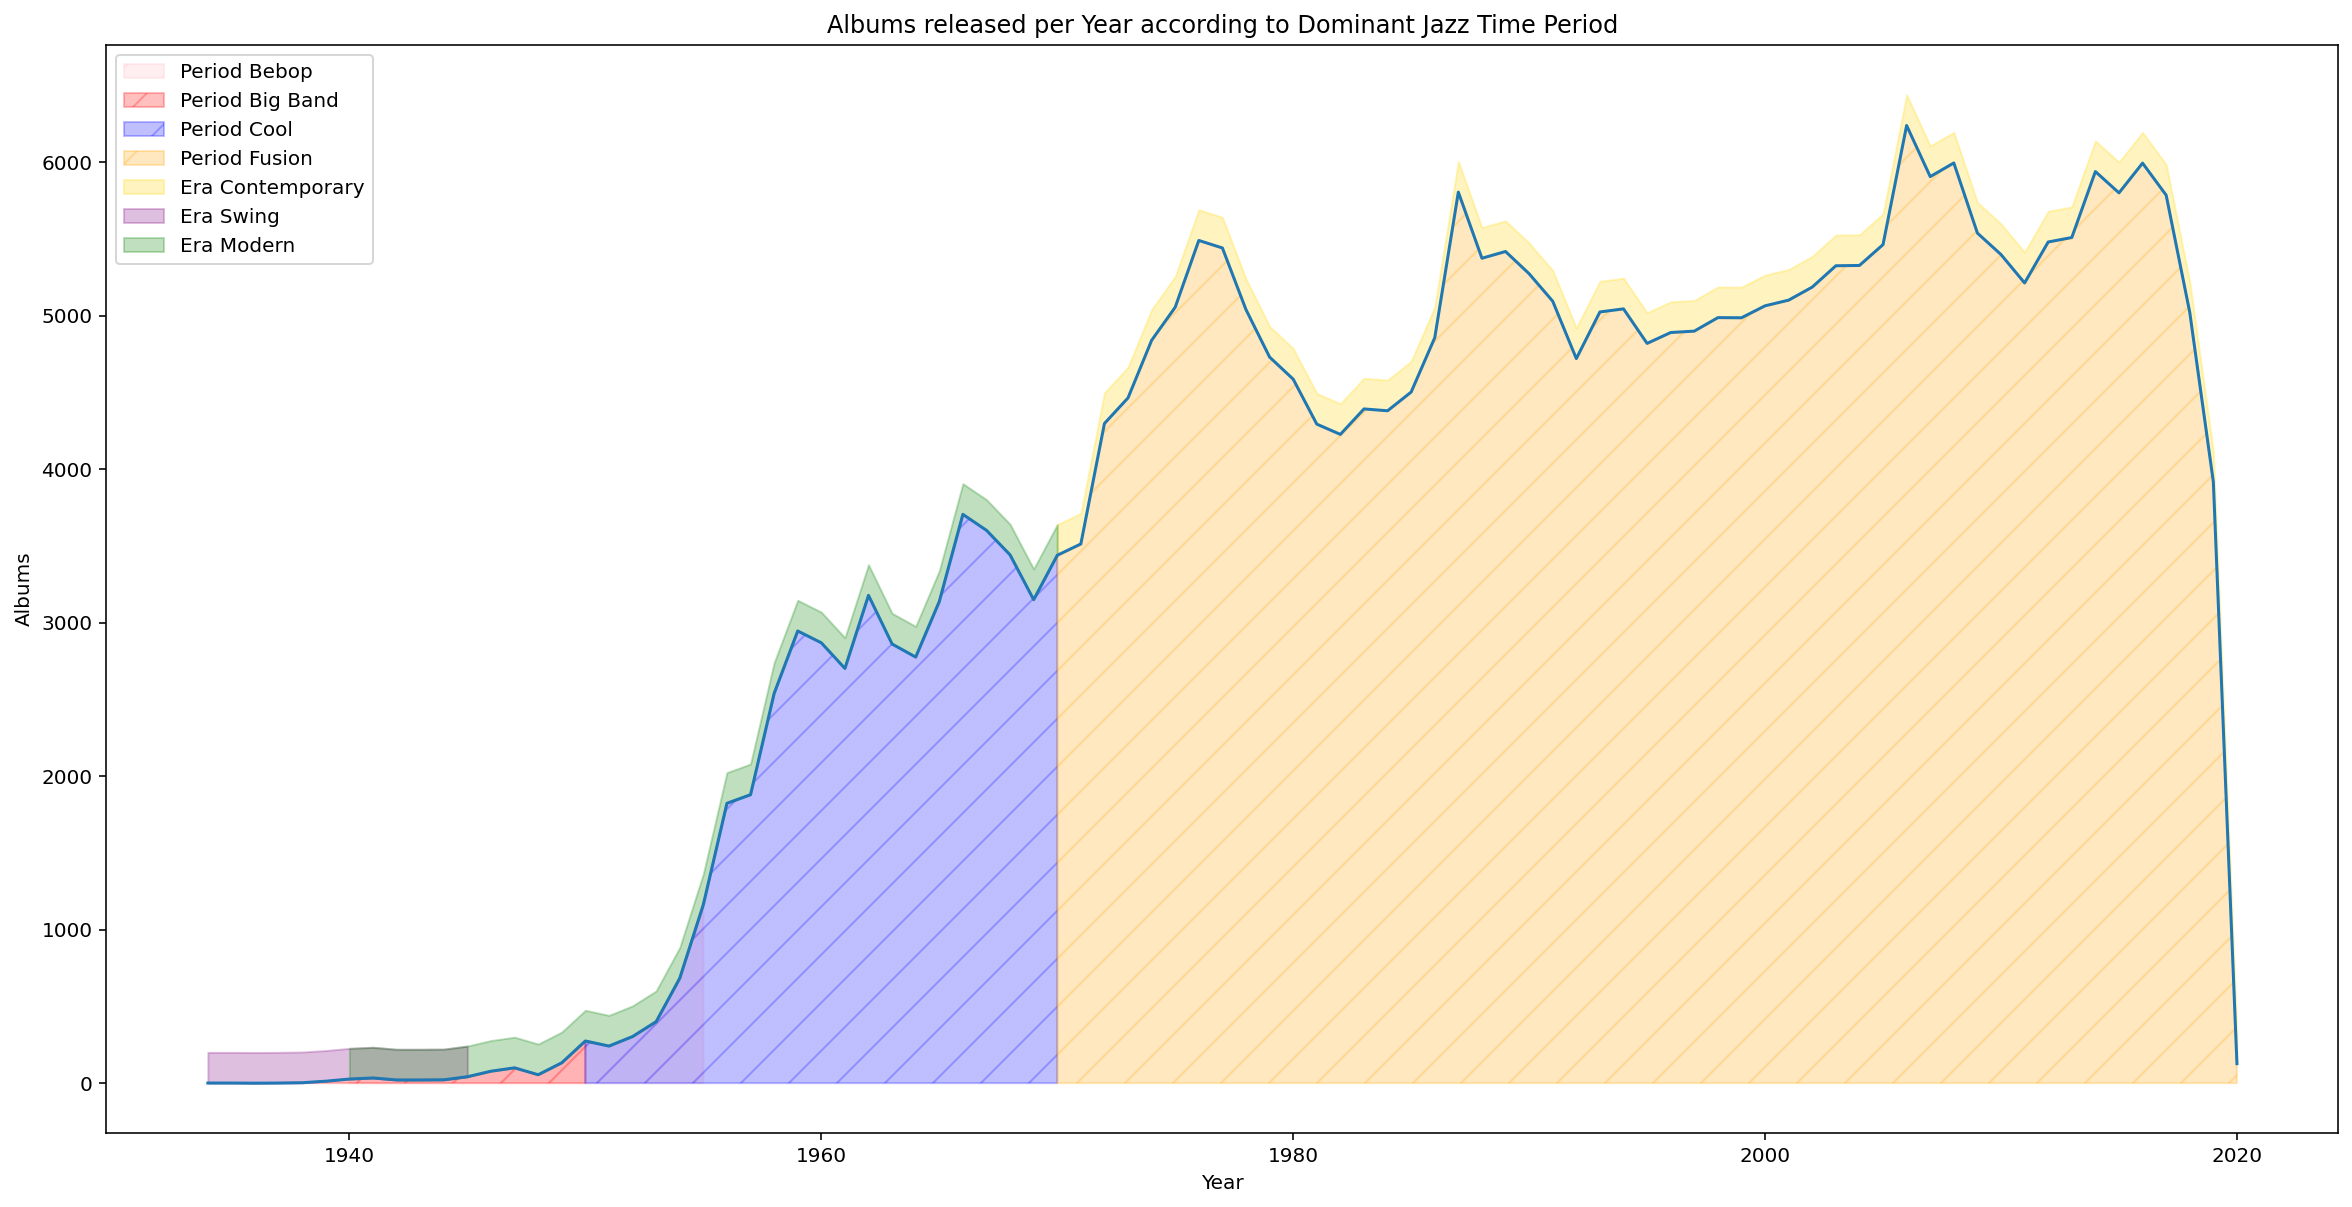

In [19]:
plot_variable_with_time_periods(year_count_series,time_period_year_range,time_period_colors,xlabel='Year',ylabel='Albums',title='Albums released per Year according to Dominant Jazz Time Period')

As we can see from the above, there was a massive explosion in the number of Jazz albums released per year in the 1950s, with a cyclical rise through the rest of the 20th century and into the 21st. In the Contemporary Jazz Era/Jazz Fusion Period, we see that the number of Jazz Albums released it at its highest, most likely due to the massive influence of Jazz on other genres.

In [20]:
pure_jazz_album_count = concat_df[concat_df[genre_columns].sum(axis=1)==0].groupby(by='year').count()['market_value']
pure_jazz_album_count[1934], pure_jazz_album_count[1936] = 0,0
pure_jazz_album_count.sort_index(inplace=True)

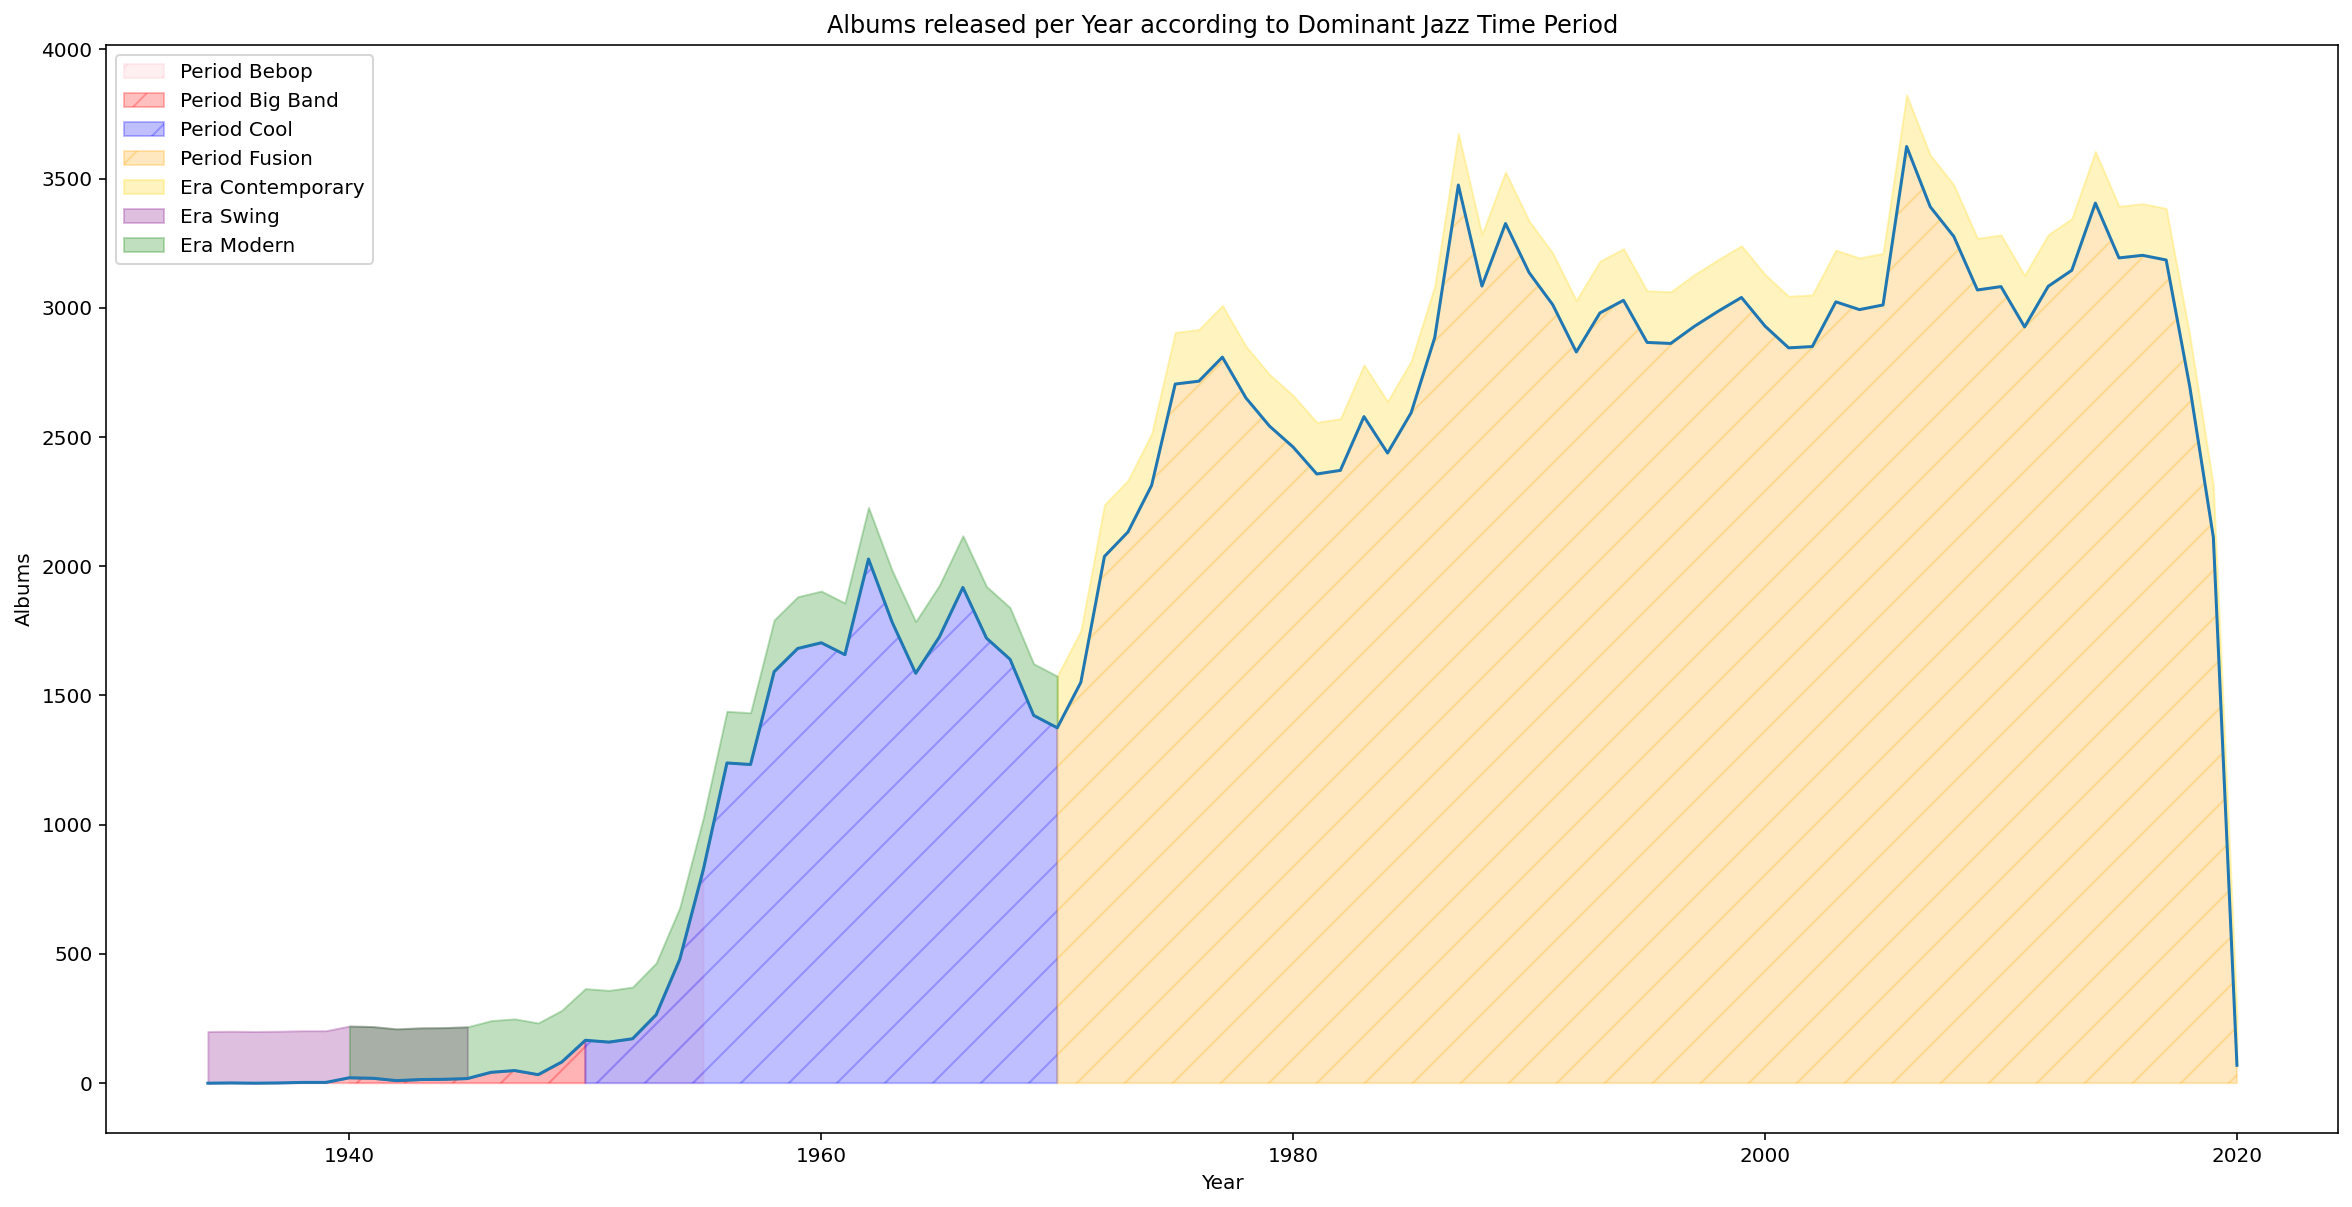

In [21]:
plot_variable_with_time_periods(pure_jazz_album_count,time_period_year_range,time_period_colors,xlabel='Year',ylabel='Albums',title='Albums released per Year according to Dominant Jazz Time Period')

As we can see, the figure above is effectively identical to the one which includes non 'Pure Jazz' albums, indicating that the rising trend in album releases is not primarily due to the incorporation of Jazz into other styles, but instead a growth of the music in its purest form over time.

## Market Value
### Distribution

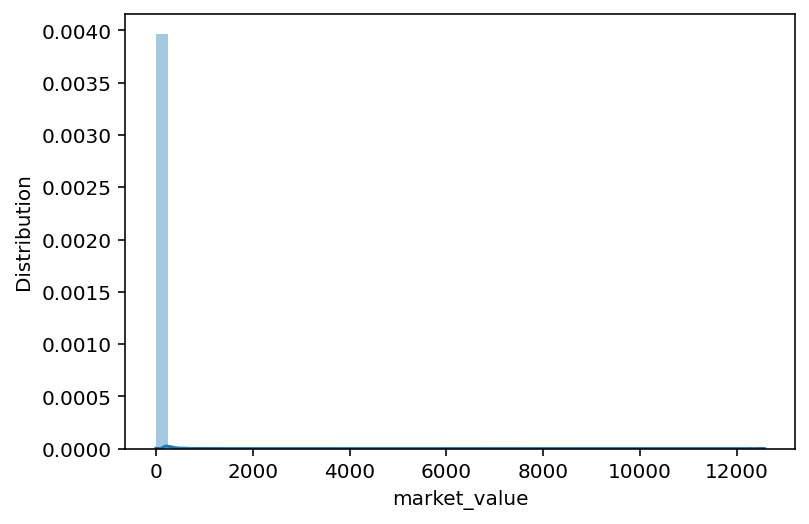

In [22]:
sns.distplot(concat_df['market_value'])
plt.ylabel('Distribution')
plt.show()

From the above we see that there is a huge left skew for market_value, which means we need to remove outliers

In [23]:
def remove_outliers(df,column):
    df = df.copy()
    col_mean,col_std = df[column].mean(), df[column].std()
    upper_bound,lower_bound = col_mean + 3*col_std, col_mean - 3*col_std
    
    df = df[df[column] < upper_bound]
    df = df[df[column] > lower_bound]
    
    return df

In [24]:
concat_df = remove_outliers(concat_df,'market_value')

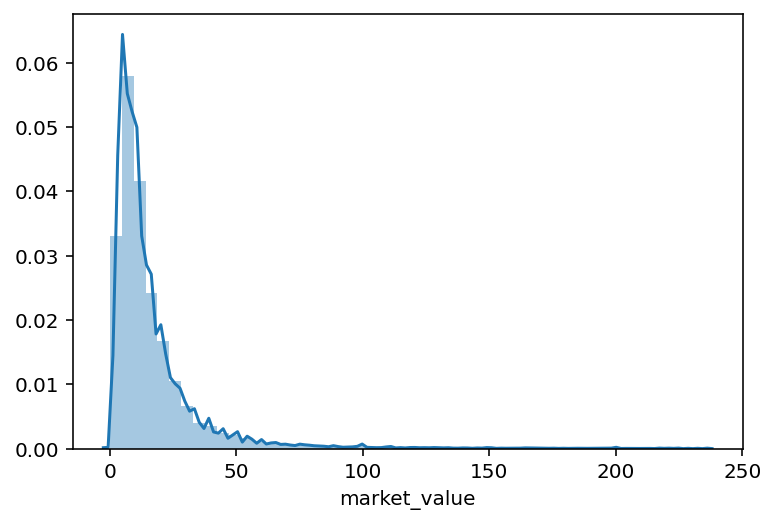

In [25]:
sns.distplot(concat_df['market_value']);

After removing entries with ``market_value`` values exceeding 3 standard deviations from the mean, we see that the distribution has skewed less, making it a prime candidate for log treatment

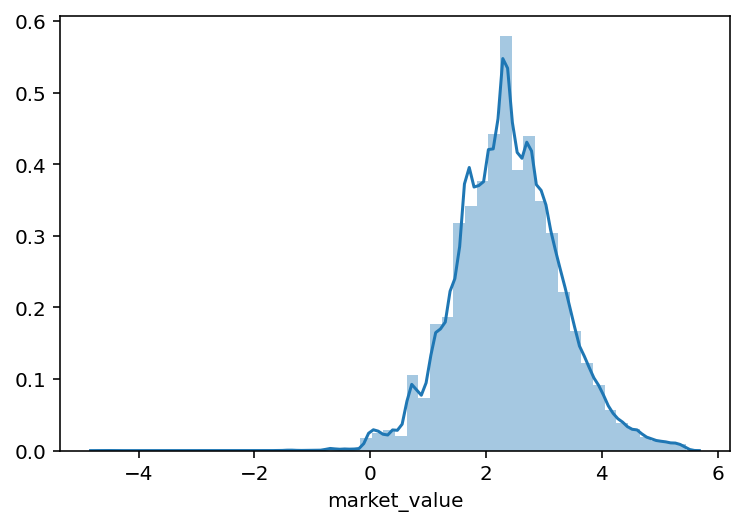

In [26]:
sns.distplot(np.log(concat_df['market_value']));

## Evolution of Market Value over Time

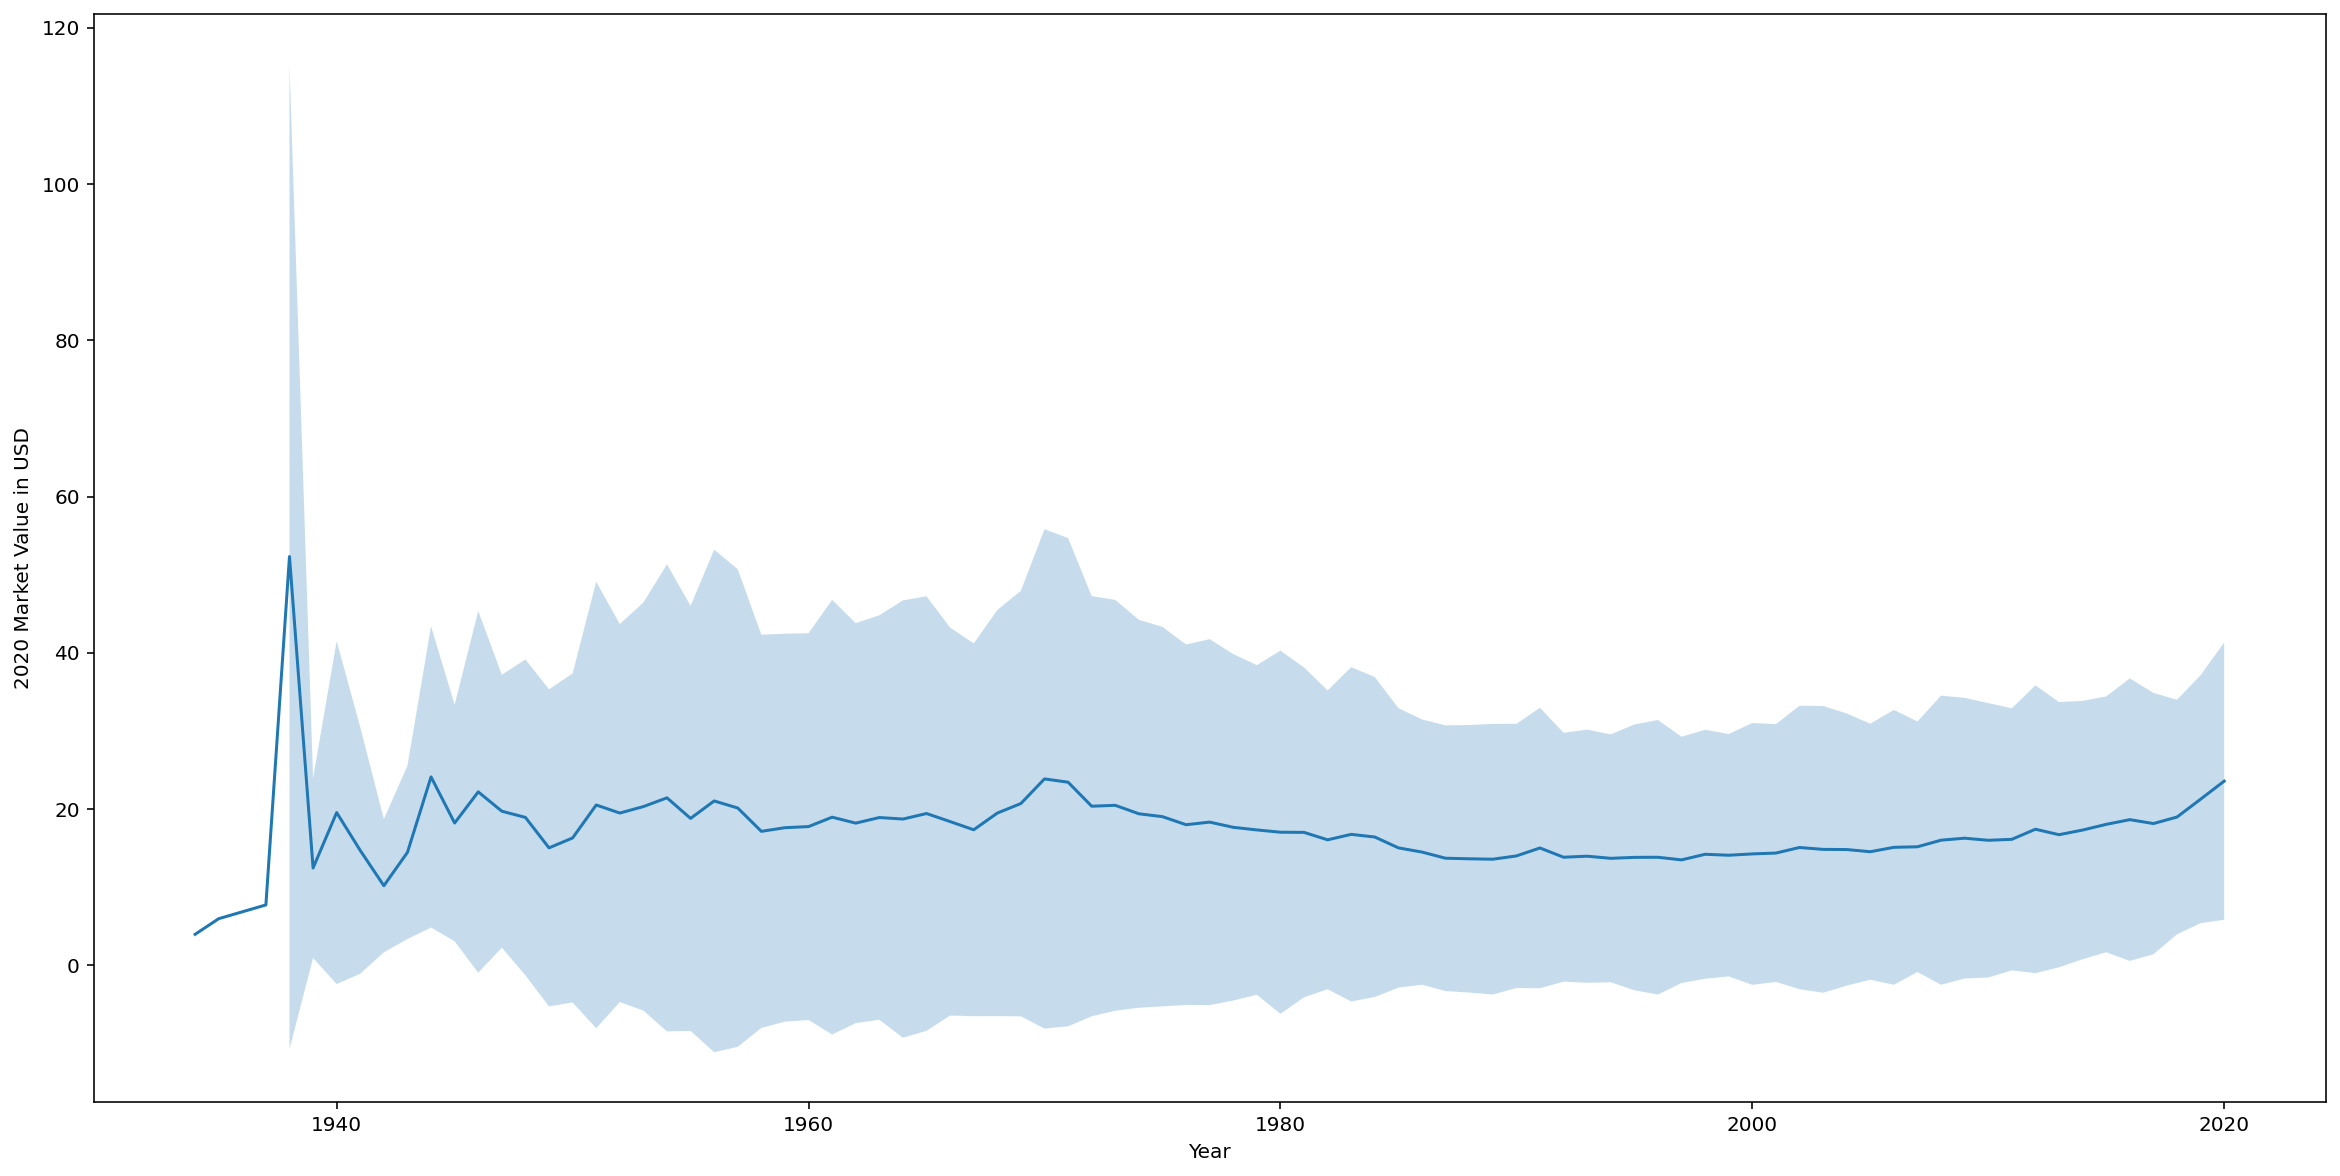

In [27]:
plt.figure(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('2020 Market Value in USD')
plt.plot(concat_df.groupby(by='year')['market_value'].mean())
mean_value = concat_df.groupby(by='year')['market_value'].mean()
std_error = concat_df.groupby(by='year')['market_value'].std()
plt.fill_between(std_error.index, mean_value-std_error, mean_value+std_error, alpha=0.25)
plt.show()

From the above, we see that even after removing the most offending outliers, there is still tremendous variation in the price of Jazz records, whic is particularly large in the mid 20th century, and slowly reduces over time, but never to a very small margin

## Correlations 

In [28]:
pairplot_columns = list(filter(lambda x: concat_df[x].dtype in (float,int) and x not in ['master_id','release_id'],rest_columns))

In [29]:
def plot_corr_subplots(df, var, var_list,nrows,ncols,figsize=(60,60)):
    
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)


    for row_idx, row in enumerate(ax):
        for col_idx, col in enumerate(row):
            row_modifier = len(var_list)-ncols*row_idx
            list_idx = len(var_list)-row_modifier+col_idx
            col_column = var_list[list_idx]
            col.set_title(col_column,fontdict={'fontsize':50})
            col.scatter(df[col_column],df[var],edgecolor='white')
    plt.show()

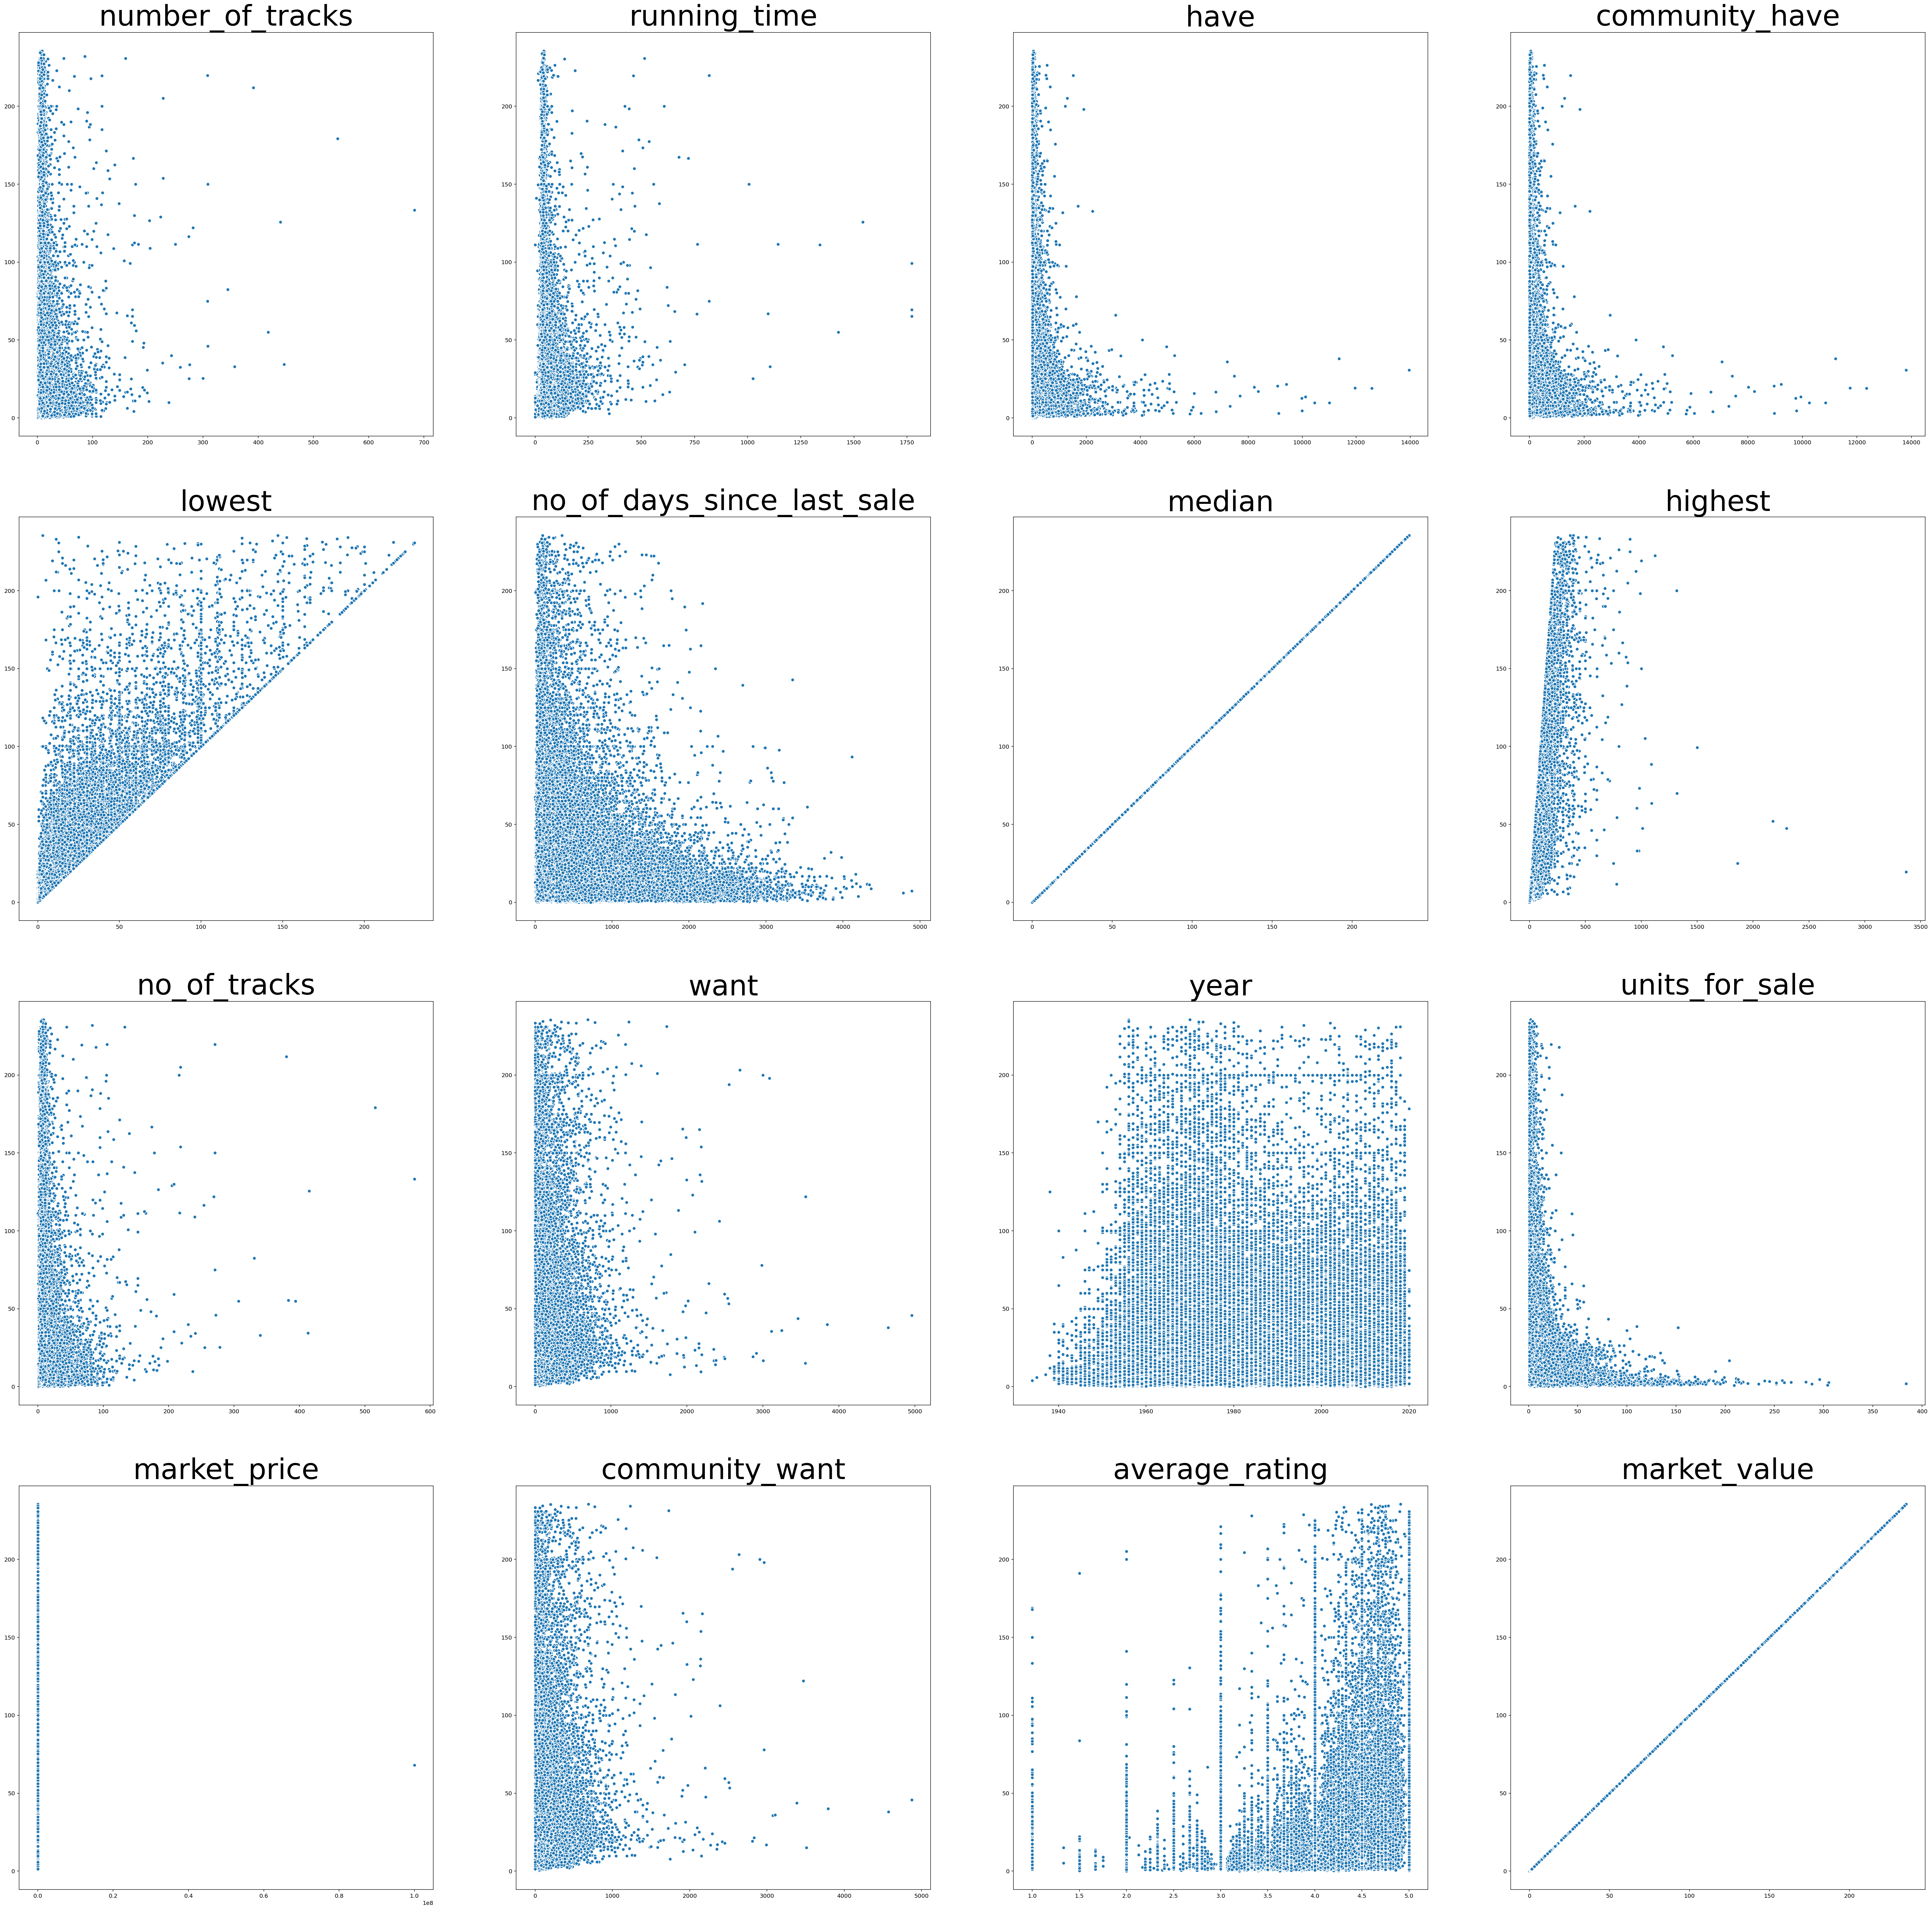

In [30]:
plot_corr_subplots(concat_df,'market_value',pairplot_columns,4,4)

As we can see from the plots above, there are not many clear relationships that can be identified between the ``market_value`` feature and the 

In [31]:
get_corr_series = lambda df,corr_column,columns: pd.Series({column:np.corrcoef(df[corr_column].values,df[column].values)[0][1] for column in columns})

In [32]:
market_value_indicator_correlations = get_corr_series(concat_df,'market_value',indicator_columns)

/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [33]:
market_value_indicator_correlations.describe()

count    800.000000
mean       0.003147
std        0.023536
min       -0.133138
25%       -0.001725
50%       -0.000115
75%        0.004716
max        0.242364
dtype: float64

From the above, it is clear that the indicator variables are not very highly correlated with ``market_value`` either. As such, we hope that via the leveraging of the multitude of categorical variables, we can improve the result of our price predictions

In [34]:
sign = market_value_indicator_correlations.apply(lambda x: 'positive' if x >= 0 else 'negative')
market_value_indicator_correlations = pd.DataFrame({'correlation': market_value_indicator_correlations.abs().values,'Sign': sign.values},index = market_value_indicator_correlations.index)

In [35]:
market_value_indicator_correlations.sort_values(by='correlation',ascending=False).head(25)

correlation      Sign
region_eastern asia                        0.242364  positive
country_japan                              0.238826  positive
superregion_asia                           0.238735  positive
format_name_Vinyl                          0.144089  positive
format_description_LP                      0.138690  positive
format_name_CD                             0.133138  negative
format_description_Limited Edition         0.132094  positive
region_north america                       0.105638  negative
style_Hard Bop                             0.095435  positive
format_description_Reissue                 0.094485  positive
superregion_europe                         0.092870  negative
country_united states of america           0.085683  negative
superregion_americas                       0.082370  negative
format_description_Test Pressing           0.078588  positive
style_Modal                                0.074450  positive
format_description_Mono                    0.070163  positive
format_description_Remastered              0.069105  positive
region_latin america and the caribbean     0.067090  positive
style_Easy Listening                       0.065417  negative
format_description_Numbered                0.064008  positive
country_brazil                             0.061967  positive
format_description_45 RPM                  0.059058  positive
country_canada                             0.056506  negative
genre_Pop                                  0.054363  negative
era_modern                                 0.053291  positive

As we can see by investigating the top correlations, albums from Japan in particular seem to be the most highly correlated with market value, followed by the formats of Vinyl and CD. Interestingly, there seems to be a positive correlation on price for Vinyl albums, and a negative correlation for CDs, which is what one would generally expect. We also observe that limited edition and reissued albums tend to be priced higher, which also makes sense. An interesting takeaway is that albums from europe and north america tend to be negatively correlated with price, which may be linked to their dominance in the genre and the sheer volume of albums they release. Furthermore, we see that the Hard Bop and Modal jazz styles tend to be the most positively correlated with ``market_value``, which is also understandable, given that these were the dominant styles during the modern jazz era, which defines the genre as a whole.

## Genres

In [36]:
def get_encoded_df_and_count(columns):
    column_df = concat_df[columns].rename(columns={column:column.split('_')[-1] for column in columns})
    column_sum = column_df.sum().sort_values(ascending=False)
    return column_df, column_sum
genre_df, genre_sum = get_encoded_df_and_count(genre_columns)

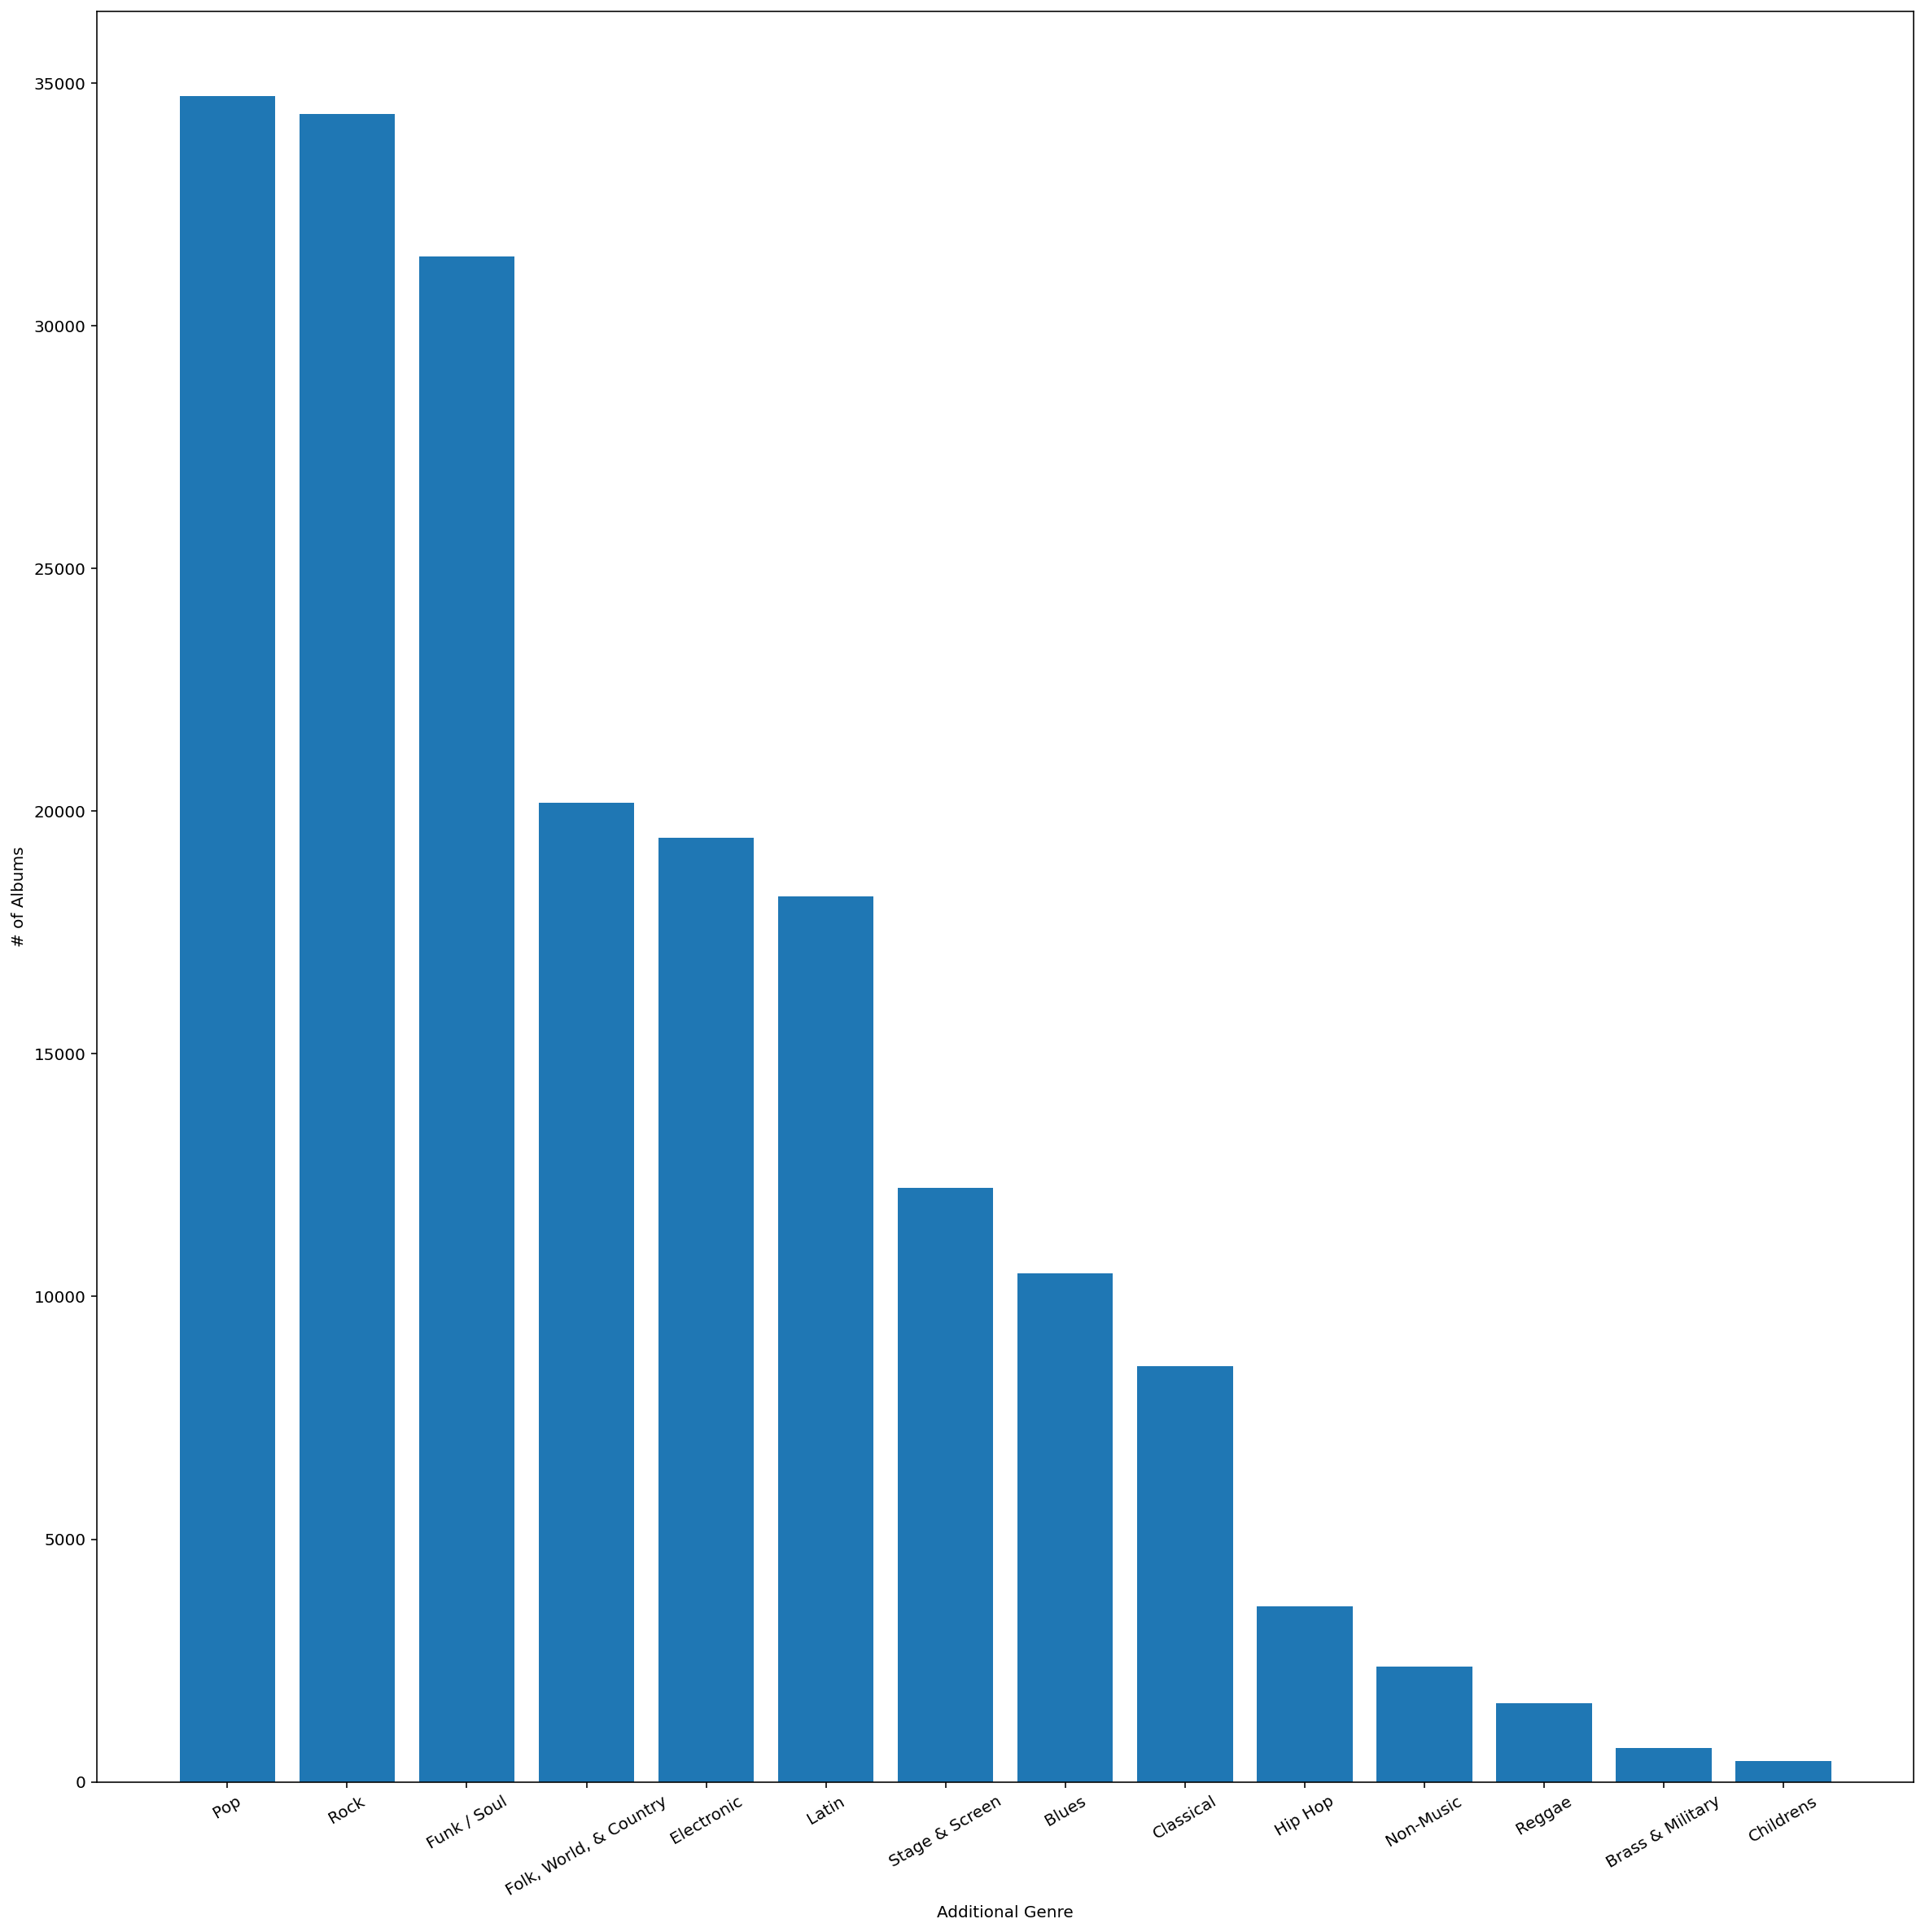

In [37]:
plt.figure(figsize=(20,20))
plt.xlabel('Additional Genre')
plt.ylabel('# of Albums')
plt.xticks(rotation=30)
plt.bar(genre_sum.index,genre_sum)
plt.show()

In [38]:
#How many 'pure' jazz albums
pure_jazz_albums = len(genre_df[genre_df.sum(axis=1)==0])
print('There are {} albums which only list Jazz as a genre, {}% of the dataset'.format(pure_jazz_albums,round(100*pure_jazz_albums/len(concat_df),2)))

There are 165777 albums which only list Jazz as a genre, 55.98% of the dataset


## Styles

In [39]:
style_df, style_sum = get_encoded_df_and_count(style_columns)
style_sum

Contemporary Jazz    36011
Easy Listening       28141
Fusion               24595
Jazz-Funk            18119
Jazz-Rock            15991
                     ...  
Keroncong                1
Occitan                  1
Zamba                    1
Skweee                   1
Makina                   1
Length: 500, dtype: int64

In [40]:
style_sum.describe()

count      500.000000
mean       931.774000
std       3368.696404
min          1.000000
25%          7.750000
50%         38.000000
75%        260.750000
max      36011.000000
dtype: float64

In [41]:
style_sum_top_10 = style_sum[style_sum > style_sum.quantile(0.9)]

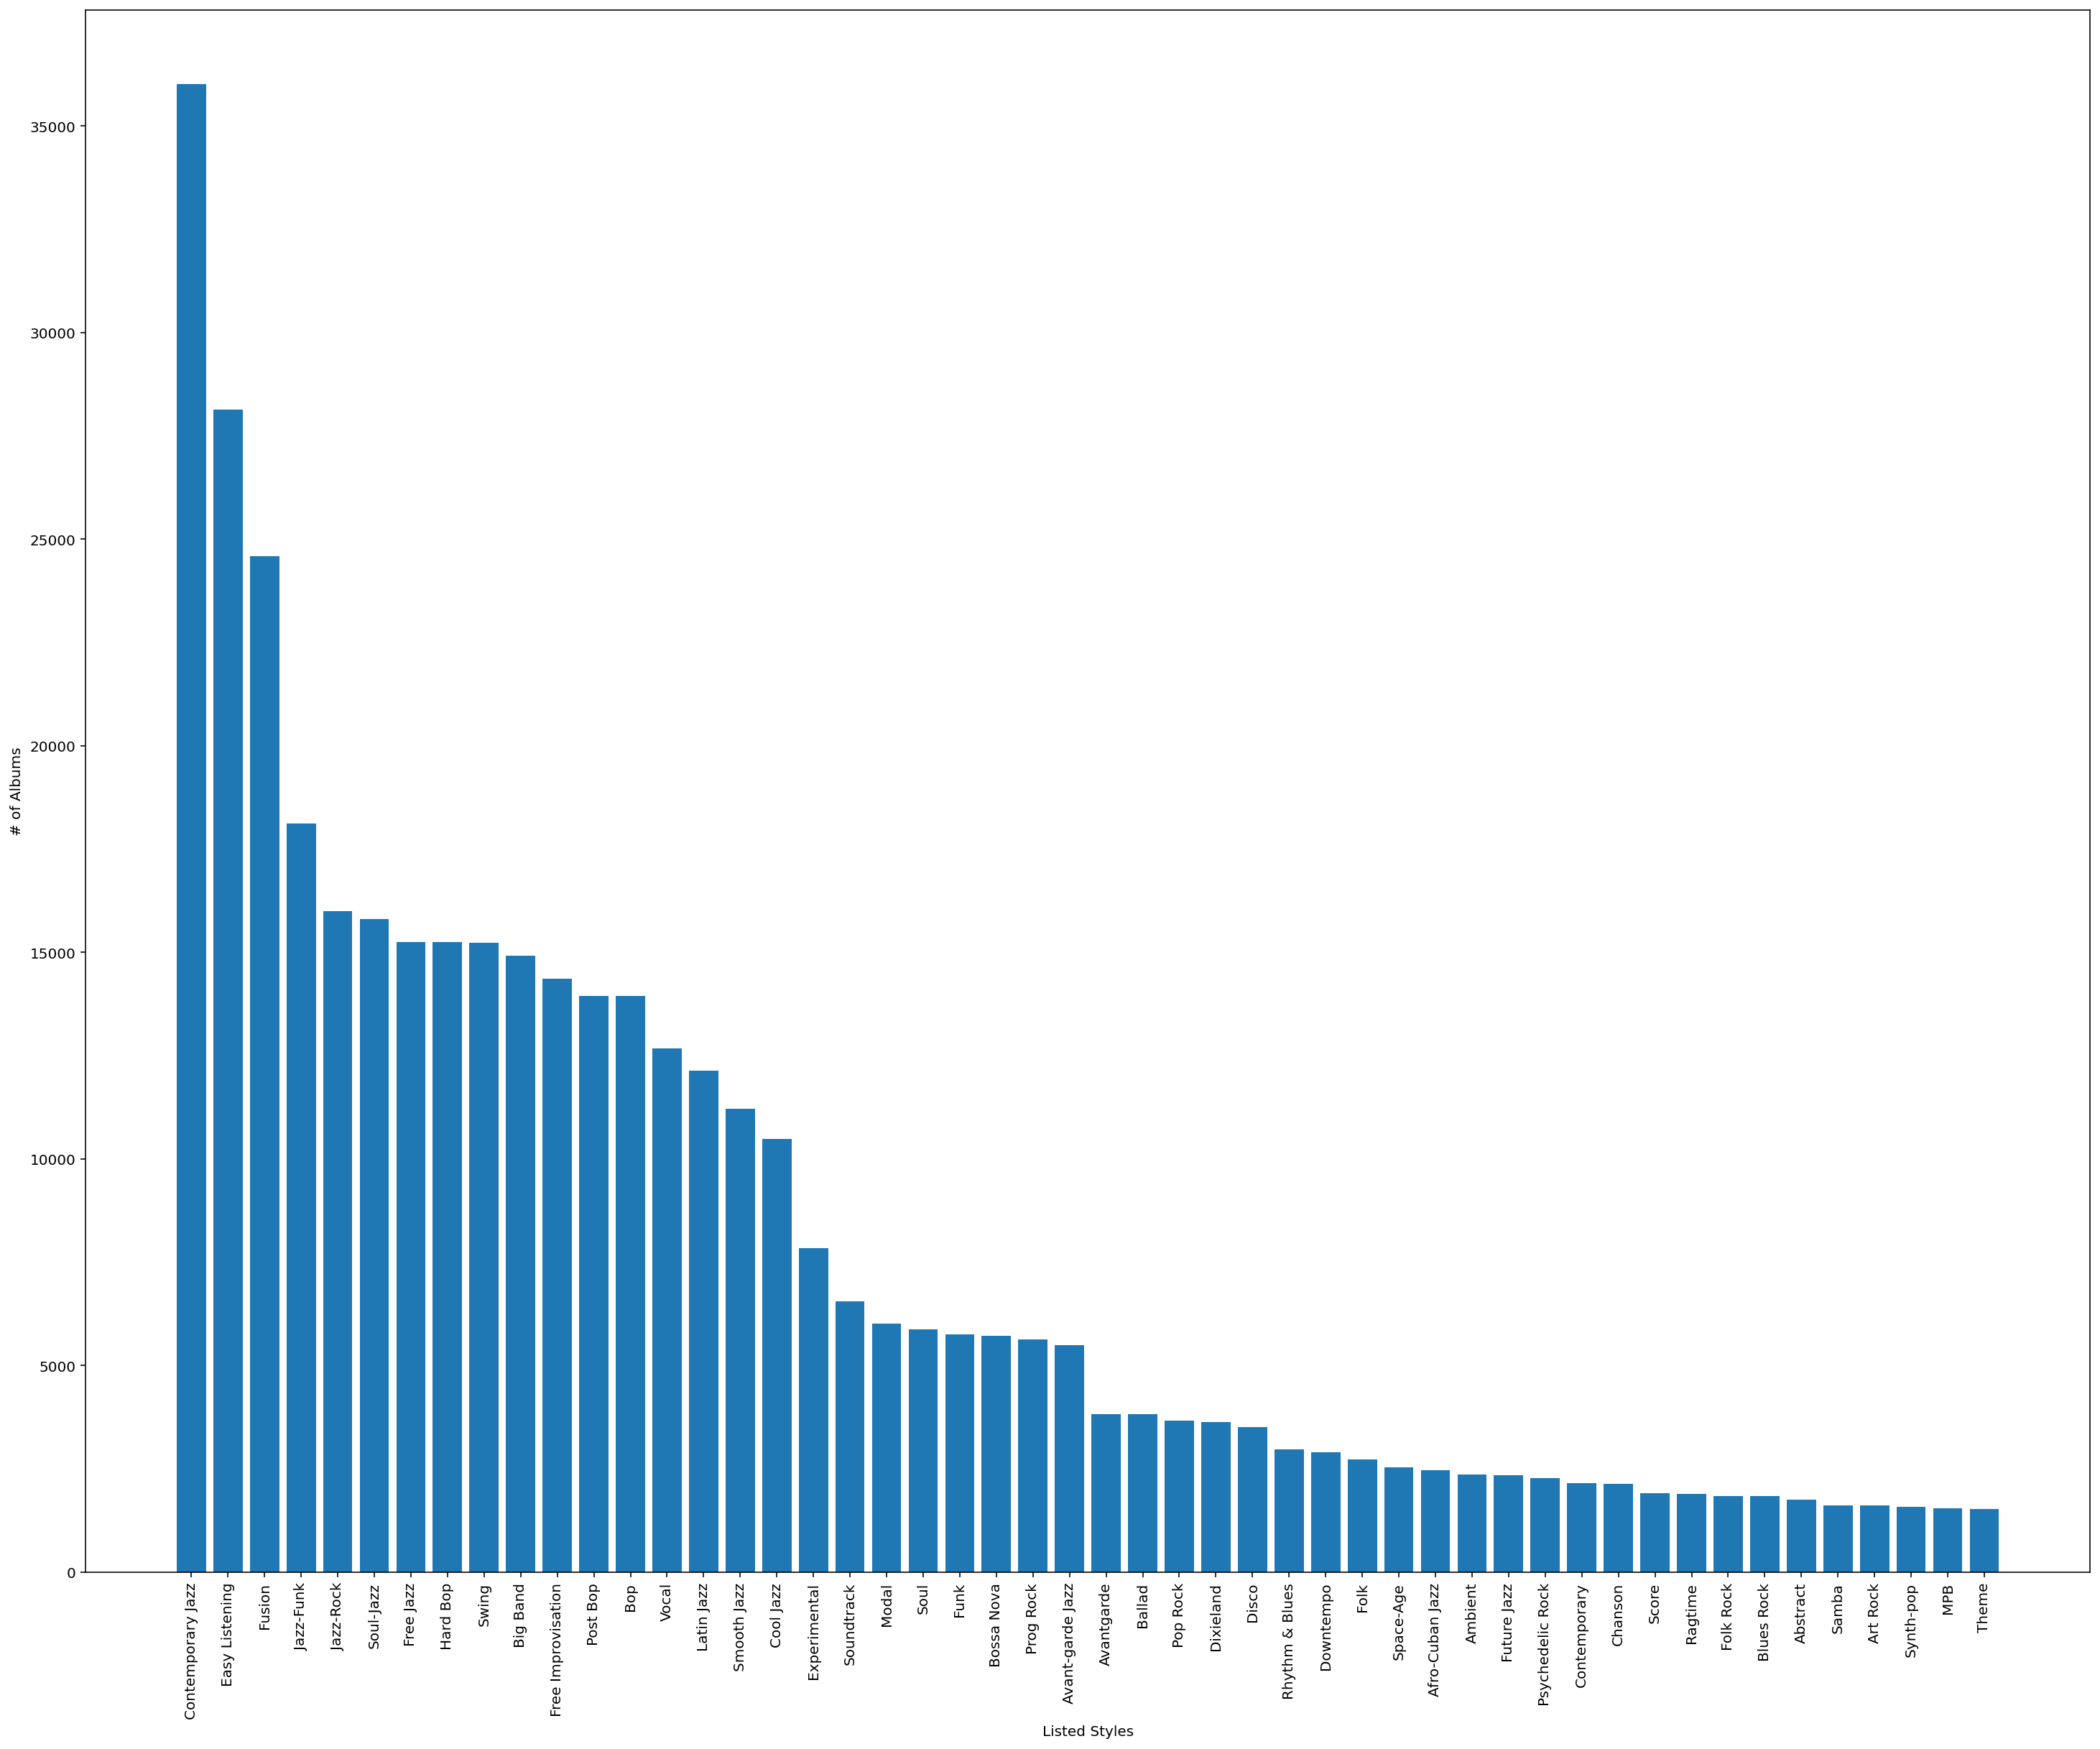

In [42]:
plt.figure(figsize=(25,20))
plt.xlabel('Listed Styles')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(style_sum_top_10.index,style_sum_top_10)
plt.show()

To reduce dimensionality, we'll only retain those features with over 250 (maybe 100) albums listed to them. We'll also construct a counter of how many styles the record has attributed to it

In [43]:
concat_df['style_count'] = concat_df[style_columns].sum(axis=1)

In [44]:
other_style_columns = list(filter(lambda x: concat_df[x].sum() < 250,style_columns))
concat_df['style_Other'] = concat_df[other_style_columns].max(axis=1)
concat_df.drop(other_style_columns,axis=1,inplace=True)

## Format Description

In [45]:
format_description_df, format_description_sum = get_encoded_df_and_count(format_description_columns)
format_description_sum.describe()

count        92.000000
mean       3704.913043
std       16285.386287
min           1.000000
25%           4.750000
50%          61.000000
75%         529.750000
max      136802.000000
dtype: float64

In [46]:
format_description_sum.iloc[:25]

LP                    136802
Reissue                61418
Stereo                 35808
Remastered             24418
Mono                   23648
Limited Edition        16518
Promo                  11060
Compilation             6284
Club Edition            3236
Repress                 3082
10"                     2733
Numbered                1588
45 RPM                  1065
Enhanced                 851
Mini-Album               849
Test Pressing            816
Hybrid                   753
12"                      752
Quadraphonic             658
7"                       613
33 ⅓ RPM                 582
Special Edition          560
Unofficial Release       541
Deluxe Edition           526
Copy Protected           471
dtype: int64

## Format Text

In [47]:
format_name_df, format_name_sum = get_encoded_df_and_count(format_name_columns)
format_name_sum.describe()

count        28.000000
mean      10576.500000
std       36556.698067
min           1.000000
25%           4.000000
50%          32.500000
75%         399.000000
max      140935.000000
dtype: float64

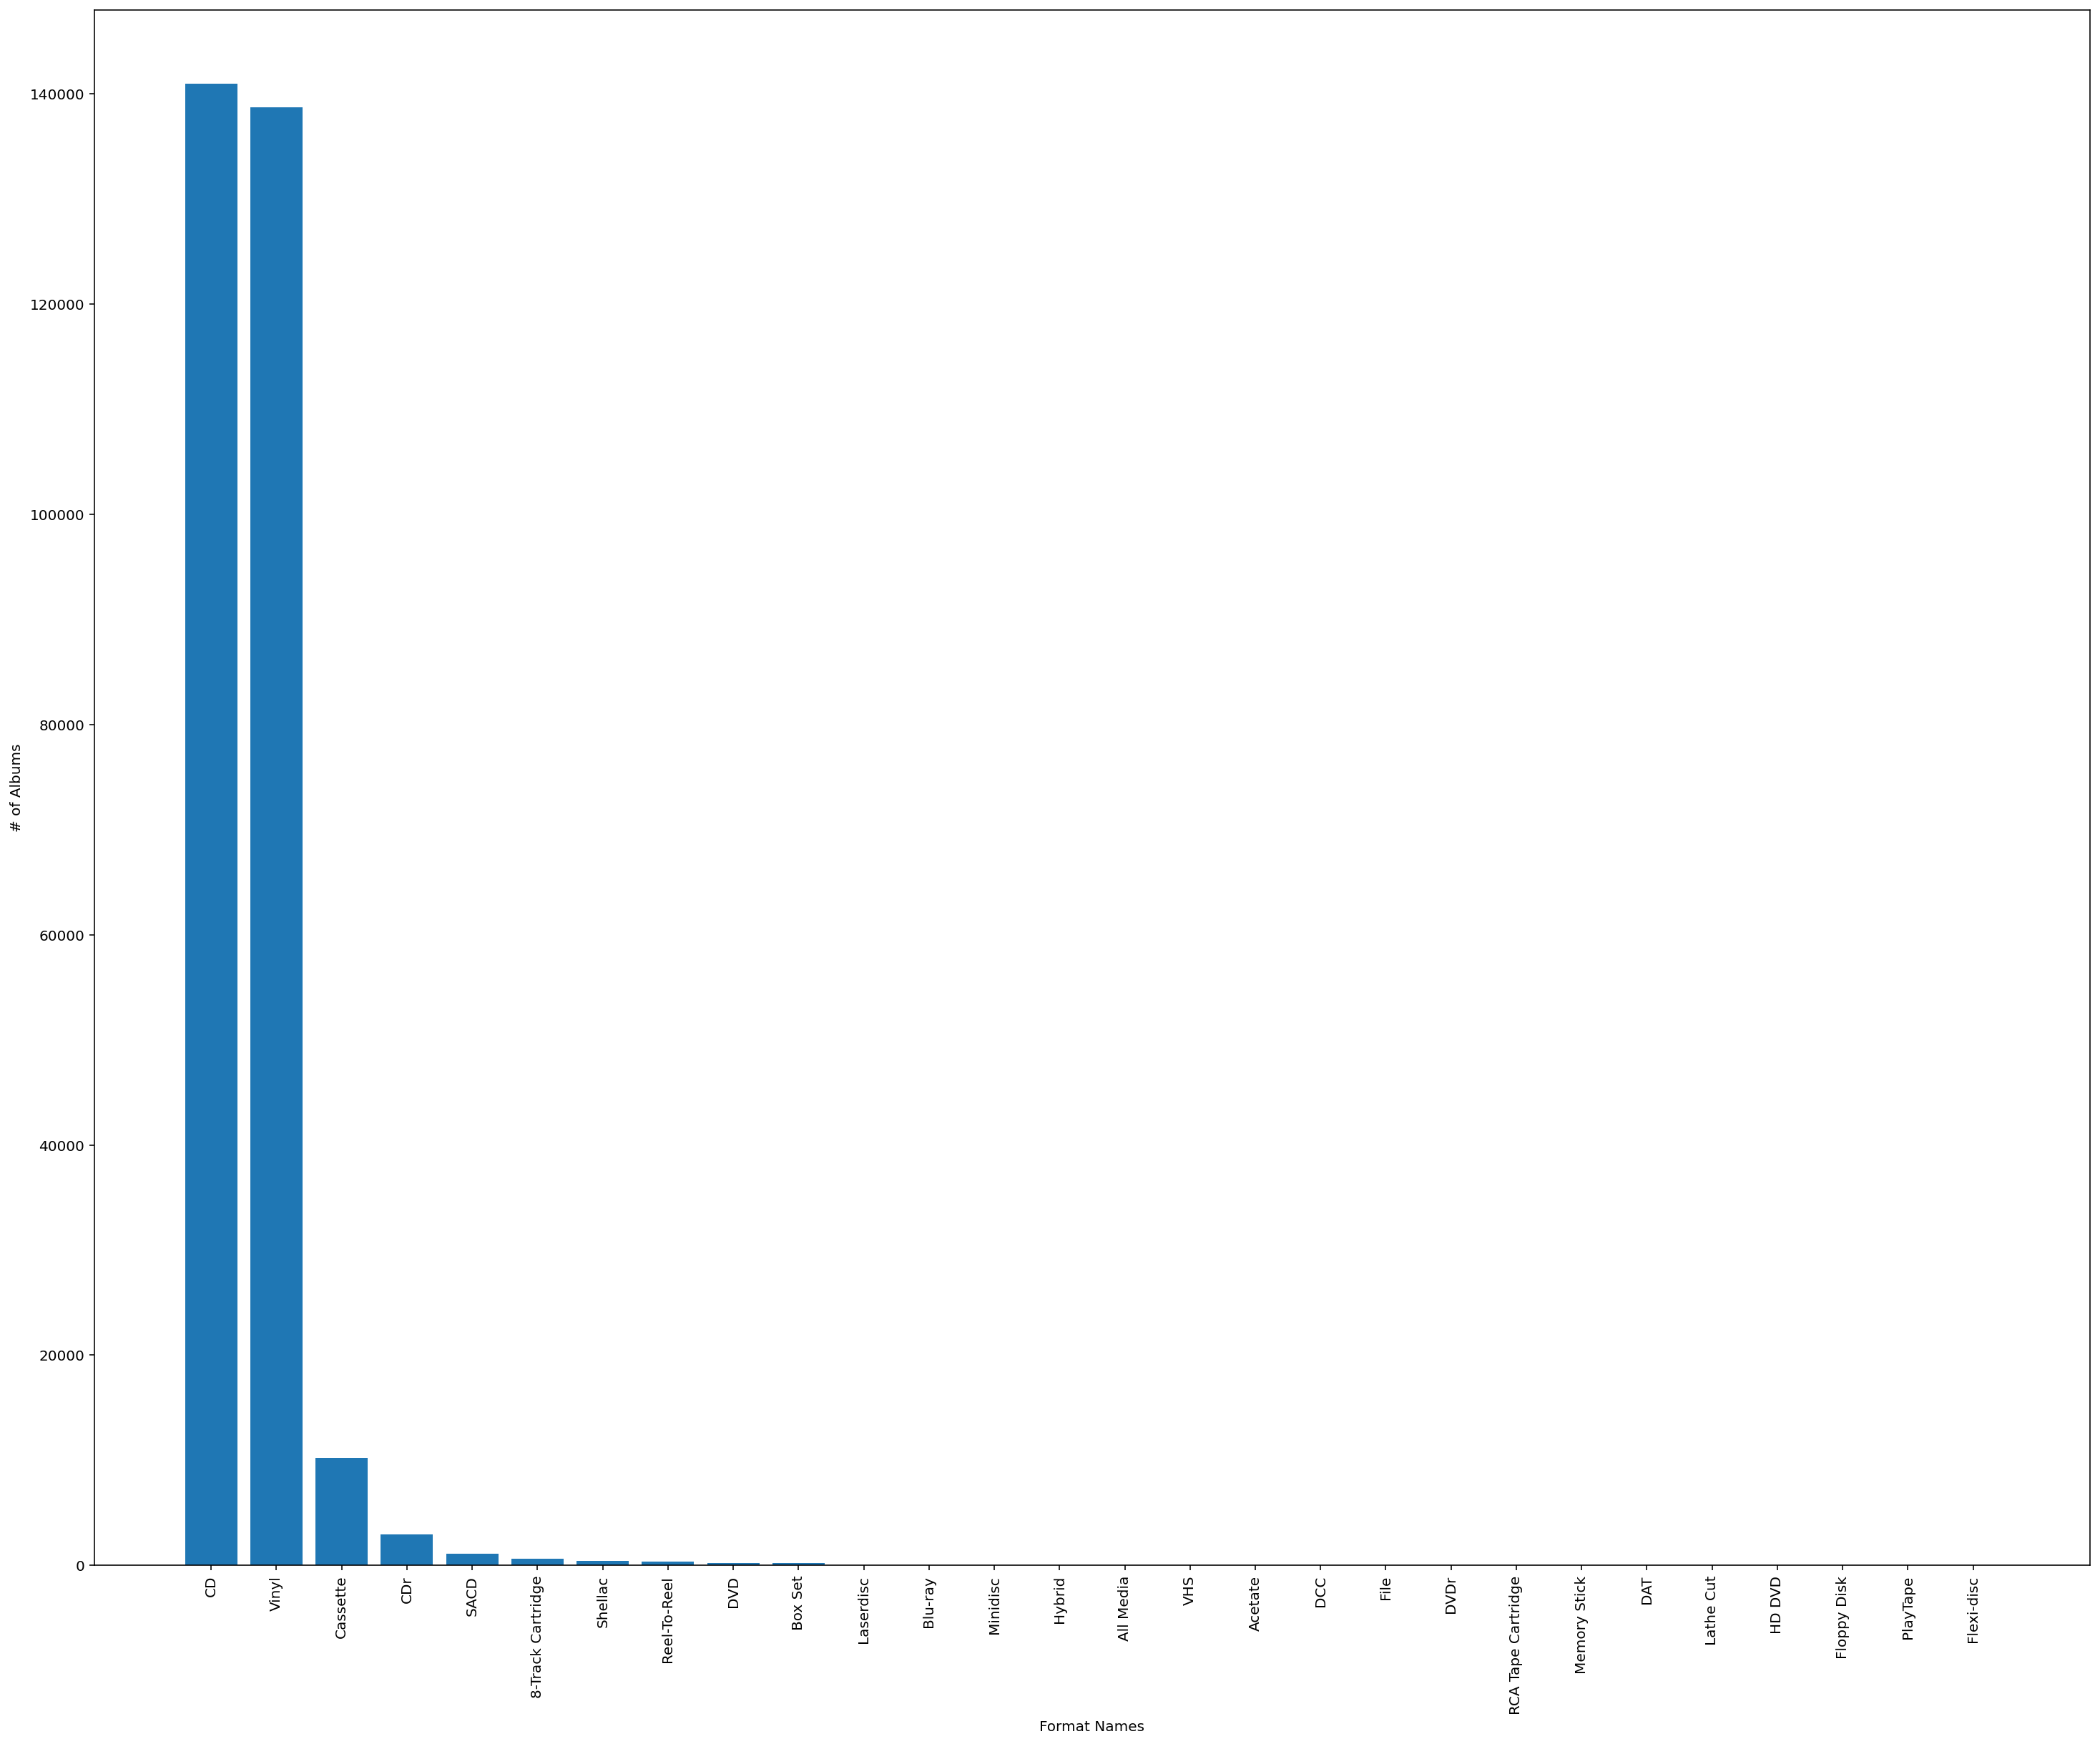

In [48]:
plt.figure(figsize=(25,20))
plt.xlabel('Format Names')
plt.ylabel('# of Albums')
plt.xticks(rotation=90)
plt.bar(format_name_sum.index,format_name_sum)
plt.show()

From the above, we can see that it would be wise to reduce the ``format_name`` indicator variable dimensionality, as there are really three non-trivially large format categories, namely ``CD``, ``Vinyl`` and ``Cassette``. The rest we will combine into an ``Other`` indicator. We will also combine ``CD`` and ``CDr``, as these formats are essentially equivalent

In [49]:
concat_df['format_name_CD'] = concat_df.loc[:,'format_name_CD'] + concat_df.loc[:,'format_name_CDr']
concat_df.drop('format_name_CDr',axis=1,inplace=True)

In [50]:
format_name_other_columns = list(filter(lambda x: x not in ['format_name_CD','format_name_Vinyl','format_name_Cassette','format_name_CDr'],format_name_columns))
concat_df['format_name_Other'] = concat_df.loc[:,format_name_other_columns].max(axis=1)

In [51]:
concat_df.drop(format_name_other_columns,axis=1,inplace=True)

## Mapping Most Albums

In [52]:
map_df = gpd.read_file(os.path.join(DATA_PATH,'countries/ne_110m_admin_0_countries.shp'))

In [53]:
visualization_countries = list(filter(lambda x: x not in ['country_yugoslavia','country_ussr','country_taiwan'],country_columns))
country_album_count = concat_df[visualization_countries].sum()

In [54]:
country_codes = pd.Series([COUNTRY_CODES[country.split('_')[-1]] for country in visualization_countries],index=visualization_countries)

In [55]:
country_df = pd.DataFrame(country_album_count)

In [56]:
country_df['codes'] = country_codes

In [57]:
country_df['ISO_A3'] = country_df.loc[:,'codes'].map(M49_TO_ISO3) 

In [58]:
country_df.sort_values(0)

0 codes ISO_A3
country_saint vincent and the grenadines                0   670    VCT
country_zambia                                          0   894    ZMB
country_cabo verde                                      1   132    CPV
country_georgia                                         1   268    GEO
country_mali                                            1   466    MLI
...                                                   ...   ...    ...
country_france                                      14644   250    FRA
country_germany                                     23432   276    DEU
country_united kingdom of great britain and nor...  23459   826    GBR
country_japan                                       39967   392    JPN
country_united states of america                    92453   840    USA

[136 rows x 3 columns]

In [59]:
merge = map_df.set_index('ISO_A3').join(country_df.set_index('ISO_A3'))

In [60]:
merge.fillna(0,inplace=True)

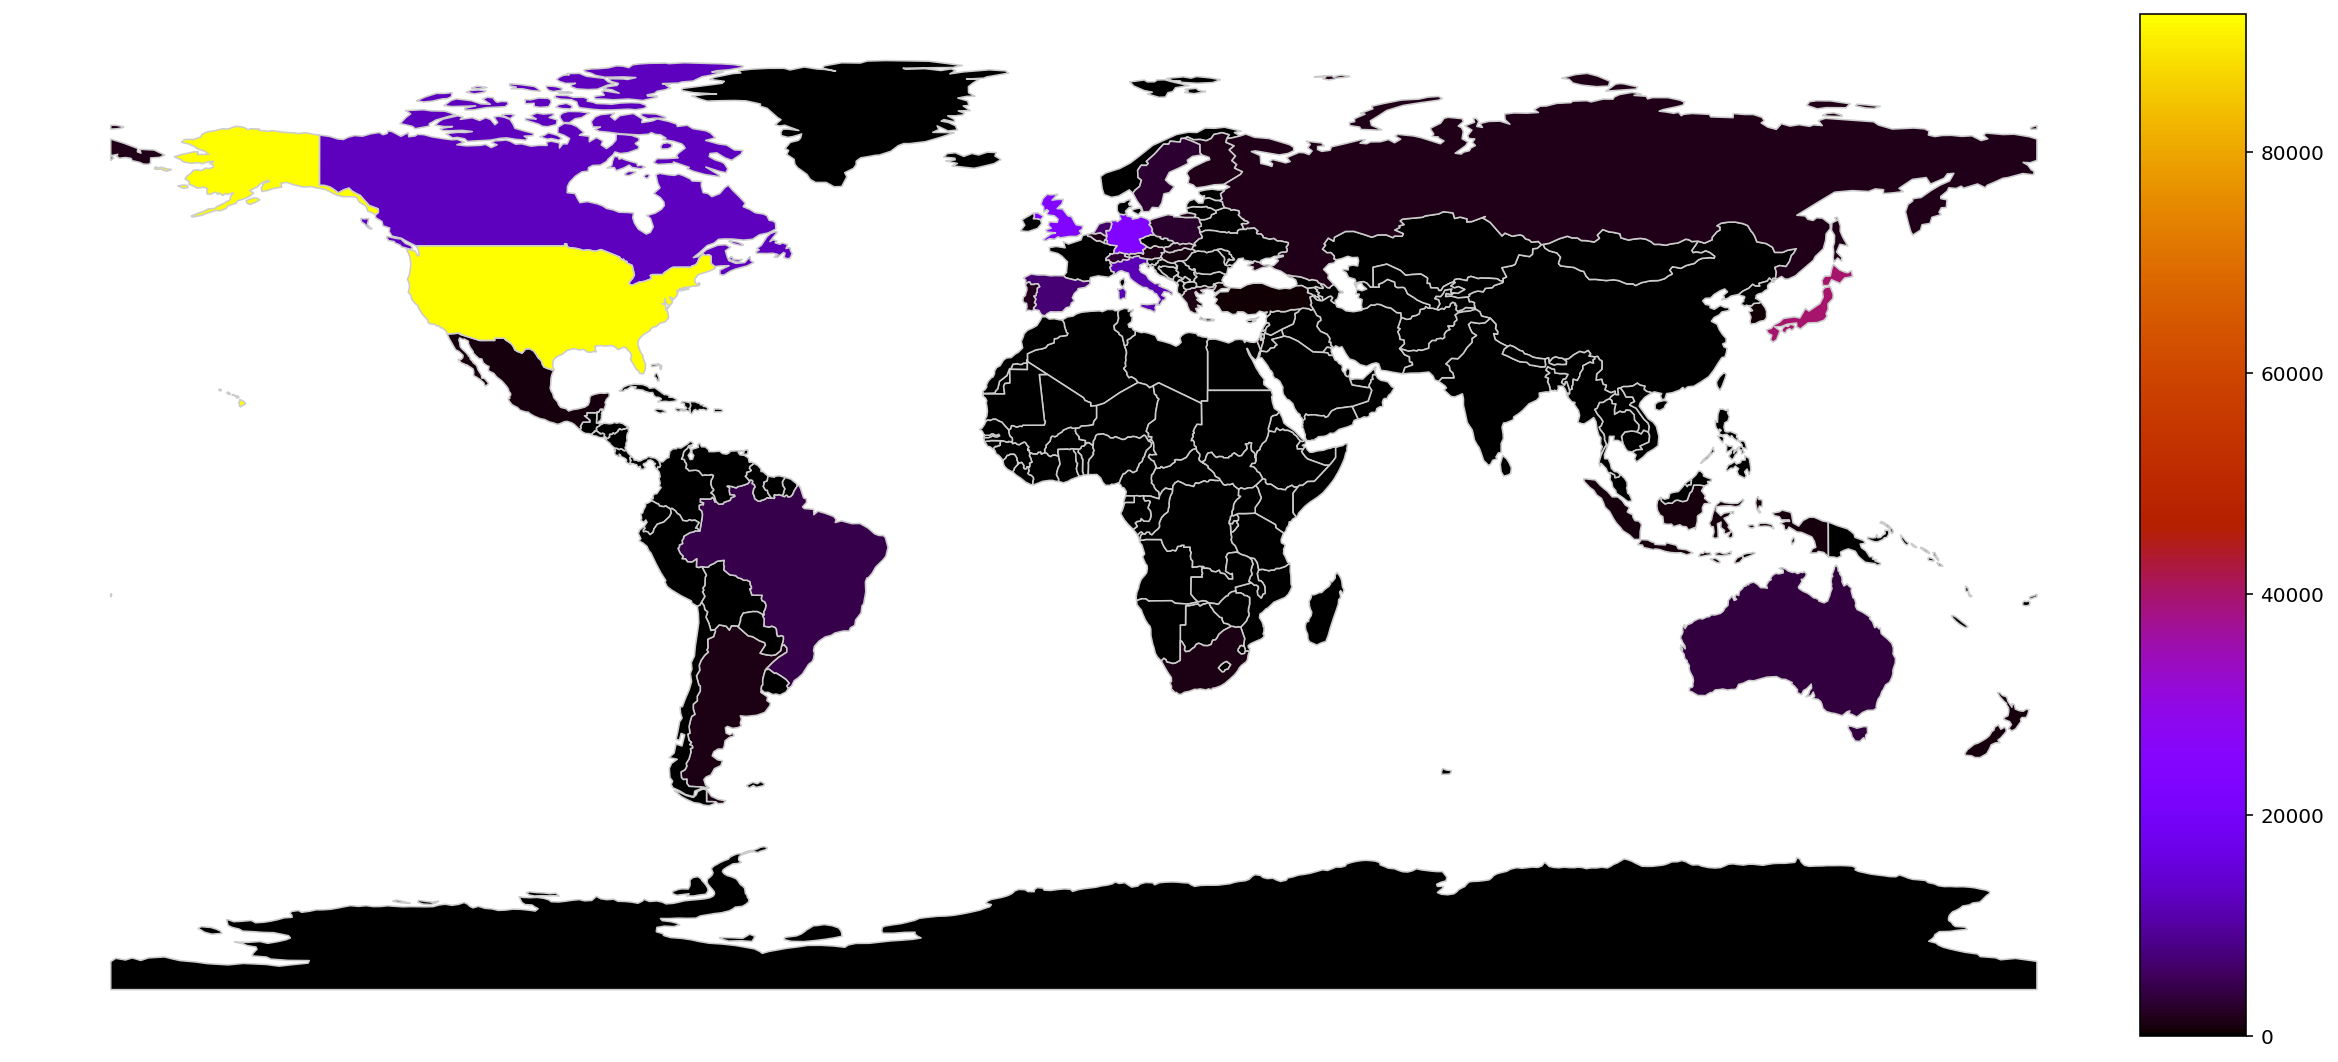

In [61]:
vmin, vmax = min(merge[0]),max(merge[0])
fig, ax = plt.subplots(1,figsize=(20,20))
merge.plot(column=0,cmap='gnuplot',linewidth=0.8,ax=ax,edgecolor='0.8')
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='gnuplot',norm=plt.Normalize(vmin=vmin,vmax=vmax))
sm._a = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm,cax=cax)
plt.show()

# High Level Features
## Loading and Cleaning

In [62]:
data_loader = DataLoader()
high_level_features = data_loader.load_high_level_features()
high_level_feature_df = pd.DataFrame()
for feature_chunk in tqdm(high_level_features):
    high_level_feature_df = pd.concat([high_level_feature_df,feature_chunk],axis=0)

36it [08:09, 13.59s/it]


In [63]:
high_level_feature_df = high_level_feature_df.reset_index(drop=True).drop('index',axis=1).astype({'release_id':np.uint32,'bitmap':np.uint8})

In [64]:
combined_df = concat_df.merge(high_level_feature_df,on='release_id',how='inner')

In [65]:
combined_df

release_id  market_price  units_for_sale   have  want  average_rating  \
0         10550056          3.99             3.0    4.0   4.0            4.00   
1          6910984          7.21             3.0    4.0   2.0             NaN   
2          8592628          7.75             5.0   17.0   0.0            5.00   
3          8684706        125.00             1.0    1.0   7.0             NaN   
4          8049748          5.00             2.0    9.0   8.0             NaN   
...            ...           ...             ...    ...   ...             ...   
295964     7340022         11.85            10.0  182.0  89.0            4.42   
295965    12058618          5.61             5.0    2.0   2.0            4.00   
295966    11534331          1.32             3.0   13.0   1.0             NaN   
295967     1572860         17.97             9.0   42.0  36.0            4.50   
295968    11010045         22.46             1.0    2.0   8.0             NaN   

        rating_count  last_sold  number_of_tracks  running_time  ...  \
0                1.0        NaT              12.0           NaN  ...   
1                0.0 2019-03-04               8.0           NaN  ...   
2                2.0        NaT               8.0           NaN  ...   
3                0.0        NaT               8.0           NaN  ...   
4                0.0 2016-12-04              12.0           NaN  ...   
...              ...        ...               ...           ...  ...   
295964          19.0 2019-12-29               5.0           NaN  ...   
295965           1.0        NaT              24.0           NaN  ...   
295966           0.0        NaT              10.0     75.383333  ...   
295967           6.0 2019-03-28               6.0     72.200000  ...   
295968           0.0        NaT              14.0           NaN  ...   

        feature_1271  feature_1272  feature_1273 feature_1274  feature_1275  \
0           0.000000      0.000000      0.000000     0.093896      0.888060   
1           0.000000      0.011237      0.000000     0.581421      1.787980   
2           0.026999      0.000000      0.000000     0.396135      0.571917   
3           0.106881      1.344922      0.000000     0.002595      0.018520   
4           0.000000      0.470421      0.008504     0.000000      0.036935   
...              ...           ...           ...          ...           ...   
295964      0.022851      1.641878      0.677245     0.000000      1.113477   
295965      0.000000      0.005240      0.109235     0.000000      1.173291   
295966      0.077323      0.012808      0.113010     1.289980      0.781575   
295967      0.000000      0.000000      0.000000     0.613954      0.000000   
295968      3.471008      0.018930      0.000000     0.000000      0.000000   

        feature_1276 feature_1277 feature_1278 feature_1279 feature_1280  
0           1.399190     0.000000     0.000000     0.077314     0.564399  
1           1.165726     0.644014     0.058192     0.052653     0.000000  
2           0.842468     0.000000     0.000000     0.031381     0.317243  
3           0.000000     0.000000     0.000000     0.030403     0.023611  
4           0.216934     0.175293     0.000000     0.000000     0.001403  
...              ...          ...          ...          ...          ...  
295964      0.111382     0.047641     0.546318     0.000000     0.071126  
295965      0.000000     0.138319     0.000000     0.000000     0.000000  
295966      0.000000     0.717500     0.134496     0.034102     0.072121  
295967      0.000000     0.000000     0.036274     0.000000     0.058438  
295968      0.007879     0.000000     0.000000     0.382585     0.539629  

[295969 rows x 1731 columns]

In [67]:
drop_cols = set(list(concat_df.columns)+['release_id','bitmap'])
data = combined_df.drop(drop_cols,axis=1)

In [68]:
scaler = StandardScaler()
pca_2d = PCA(n_components=2,random_state=0)
pca_3d = PCA(n_components=3,random_state=0)
scale_pca_2d = Pipeline([('scaler',scaler),('pca',pca_2d)])
scale_pca_3d = Pipeline([('scaler',scaler),('pca',pca_3d)])

In [69]:
embedding_2d = scale_pca_2d.fit_transform(data)
embedding_3d = scale_pca_3d.fit_transform(data)

In [70]:
embedding_nd_columns = lambda n: ['embedding_%sd_%s' % (n,i) for i in range(n)]
embedding_2d_columns, embedding_3d_columns = embedding_nd_columns(2), embedding_nd_columns(3)

In [71]:
combined_df = pd.concat(
    [combined_df,
     pd.DataFrame(embedding_2d,columns=embedding_2d_columns),
     pd.DataFrame(embedding_3d,columns=embedding_3d_columns)
    ],
    axis=1)

In [72]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [73]:
def plot_indicator_3d(df, columns, embedding_columns=None,**kwargs):
    df = df.copy()
    if not embedding_columns:
        embedding_columns = list(filter(lambda x: 'embedding_3d' in x,df.columns))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if kwargs.get('colors'):
        colors = kwargs.get('colors')
    else:
        cmap = get_cmap(len(columns))
        colors = [cmap(index) for index in range(len(columns))]
                  
    for index,column in enumerate(columns):
        column_embedding = df[df[column]==1][embedding_columns]
        ax.scatter(
            column_embedding.iloc[:,0],
            column_embedding.iloc[:,1],
            column_embedding.iloc[:,2],
            label=column.split('_')[-1],
            color=colors[index],
            alpha=0.75
        )
    
    ax.legend()

In [74]:
def plot_indicator_2d(df, columns,embedding_columns=None,**kwargs):
    df = df.copy()
    if not embedding_columns:
        embedding_columns = list(filter(lambda x: 'embedding_2d' in x,df.columns))
    cmap = get_cmap(len(columns))
    plt.figure(figsize=(10,10))
    
    if kwargs.get('colors'):
        colors = kwargs.get('colors')
    else:
        cmap = get_cmap(len(columns))
        colors = [cmap(index) for index in range(len(columns))]  
    
    for index,column in enumerate(columns):
        column_embedding = df[df[column]==1][embedding_columns]
        plt.scatter(
            column_embedding.iloc[:,0],
            column_embedding.iloc[:,1],
            label=column.split('_')[-1],
            color=colors[index],
            alpha=0.25,
            edgecolor='white'
        )
    
    plt.legend()

/Users/simonhelmig/anaconda3/envs/exts-ml/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


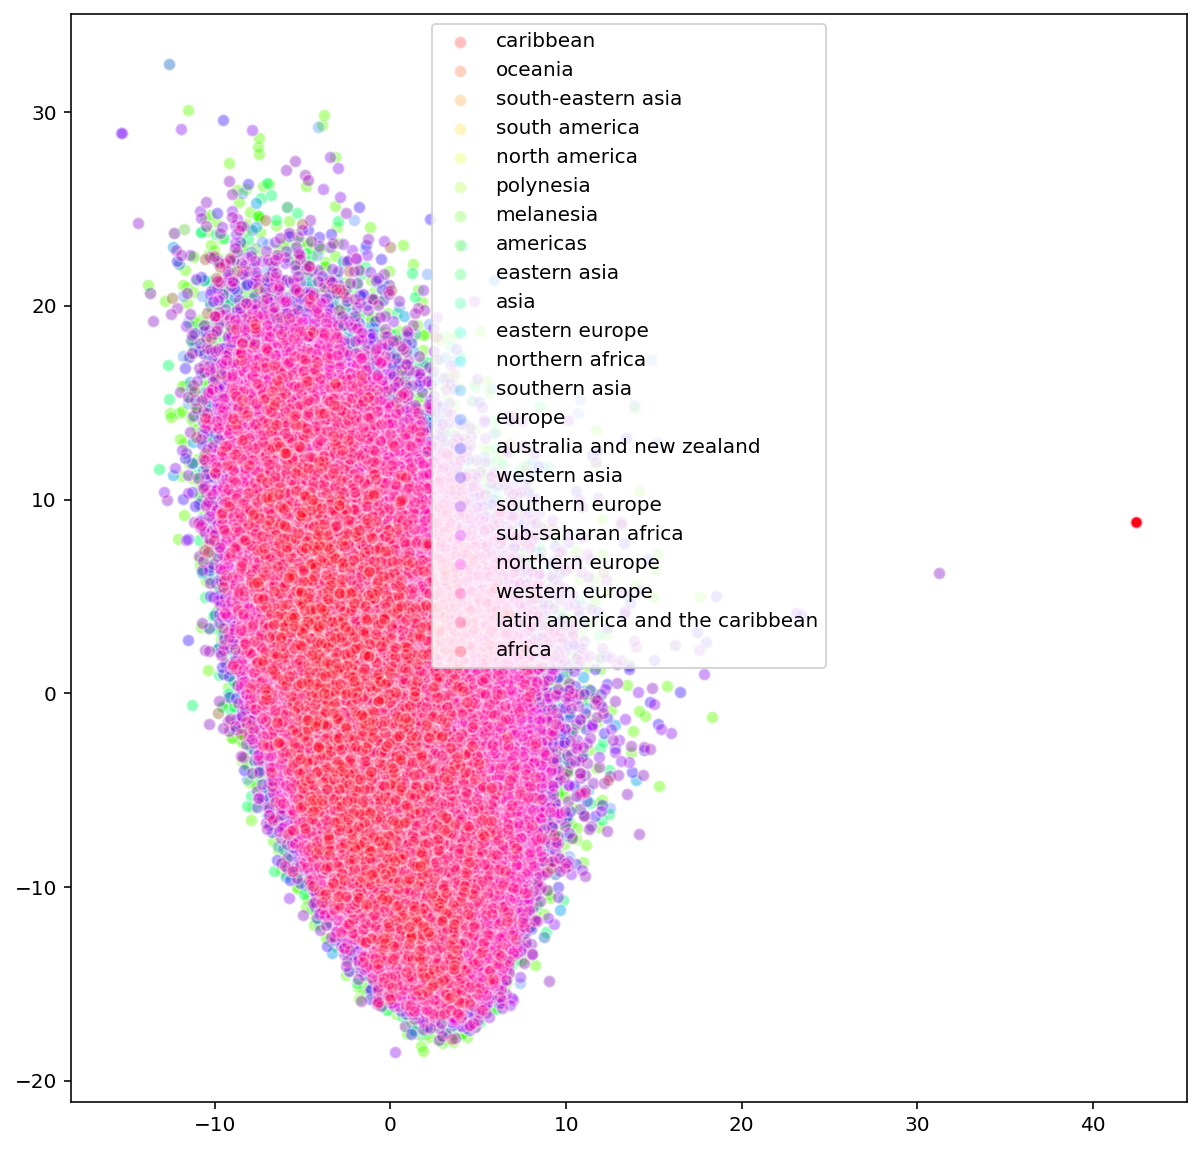

In [75]:
plot_indicator_2d(combined_df,region_columns,embedding_2d_columns)

In [76]:
combined_df['market_value'].quantile([0.25,0.5,0.75,1])

0.25      6.000000
0.50     10.880000
0.75     19.500000
1.00    235.539112
Name: market_value, dtype: float64

In [77]:
def identify_quantile(x,lower,upper):
    if x >= lower and x <= upper:
        return 1
    return 0

In [78]:
for quantile in [0.25,0.5,0.75,1]:
    combined_df['market_value_quantile_%s' % quantile] = combined_df['market_value'].apply(identify_quantile,lower=combined_df['market_value'].quantile(quantile-0.25),upper=combined_df['market_value'].quantile(quantile))

In [79]:
market_value_quantiles = list(filter(lambda x: 'market_value_quantile' in x,combined_df.columns))
combined_df[market_value_quantiles].describe()

market_value_quantile_0.25  market_value_quantile_0.5  \
count               295969.000000              295969.000000   
mean                     0.254337                   0.251763   
std                      0.435489                   0.434026   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      1.000000                   1.000000   
max                      1.000000                   1.000000   

       market_value_quantile_0.75  market_value_quantile_1  
count               295969.000000            295969.000000  
mean                     0.250928                 0.250307  
std                      0.433548                 0.433190  
min                      0.000000                 0.000000  
25%                      0.000000                 0.000000  
50%                      0.000000                 0.000000  
75%                      1.000000                 1.000000  
max                      1.000000                 1.000000

In [80]:
%matplotlib widget

In [81]:
random_sample = [int(random.random()*len(combined_df)) for i in range(5000)]

In [82]:
test = combined_df.loc[random_sample,:]

In [83]:
plot_indicator_3d(test,market_value_quantiles,embedding_3d_columns,colors=['blue','orange','red','green'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'NoneType' object has no attribute '_send_event'

<Figure size 720x720 with 1 Axes>

In [84]:
market_value_embedding_3d_correlations = pd.Series({column:np.corrcoef(combined_df['market_value'].values,combined_df[column].values)[0][1] for column in ['embedding_3d_%s' % i for i in range(3)]})

In [85]:
market_value_embedding_3d_correlations

embedding_3d_0   -0.003389
embedding_3d_1   -0.041278
embedding_3d_2    0.031364
dtype: float64

In [86]:
pca_10d = PCA(n_components=10,random_state=0)
scale_pca_10d = Pipeline([('scaler',scaler),('pca',pca_10d)])

In [87]:
embedding_10d = pca_10d.fit_transform(data)
embedding_10d_columns = embedding_nd_columns(10)

In [88]:
combined_df = pd.concat([
    combined_df,
    pd.DataFrame(embedding_10d,columns=embedding_10d_columns)
    ],axis=1
)

In [89]:
get_corr_series(combined_df,'market_value',embedding_10d_columns)

embedding_10d_0   -0.006976
embedding_10d_1   -0.049230
embedding_10d_2    0.007171
embedding_10d_3   -0.001489
embedding_10d_4    0.058640
embedding_10d_5   -0.004113
embedding_10d_6   -0.035896
embedding_10d_7   -0.018066
embedding_10d_8    0.001501
embedding_10d_9    0.023966
dtype: float64

In [90]:
combined_df.drop(embedding_2d_columns+embedding_3d_columns,axis=1,inplace=True)

In [91]:
save_to_pkl(combined_df,'combined')

## Preparing for Machine Learning

## Exporting Data

In [ ]:
train_df = pd.concat([X_tr,y_tr],axis=1)
test_df = pd.concat([X_te,y_te],axis=1)

In [ ]:
save_to_pkl(train_df,'train')
save_to_pkl(test_df,'test')